In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream
#warnings.filterwarnings("ignore")

In [5]:
# Windows
path_estreams = r'C:\Users\nascimth\Documents\data\EStreams'

In [6]:
## Mac
#path_estreams = r'/Users/thiagomedeirosdonascimento/Downloads/Python 2/Scripts/estreams_part_b/data/EStreams'

In [7]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'/streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)



# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [8]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [9]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [10]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


#estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
#estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<00:00, 263.15it/s]


In [11]:
# Read the dataset network
estreams_attributes_clipped_filters = pd.read_csv(R'..\data\network_estreams_moselle_108_gauges.csv', encoding='utf-8')
estreams_attributes_clipped_filters.set_index("basin_id", inplace = True)
estreams_attributes_clipped_filters

,Unnamed: 0,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,...,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2,group
basin_id,,,,,,,,,,,,,,,,,,,,,
LU000018,0,5,Schoenfels,LU,LU_CONTACTFORM,Mamer,6.100795,49.723112,6.100795,49.723112,...,0.015,0.015,17.0,39.0,61.0,0.0,0.0,100.0,0.0,Group_1
LU000010,1,6,Hunnebuer,LU,LU_CONTACTFORM,Eisch,6.079524,49.729184,6.079524,49.729184,...,0.026,0.026,16.0,42.0,58.0,0.0,1.0,99.0,0.0,Group_1
LU000001,2,17,Bigonville,LU,LU_CONTACTFORM,Sure,5.801399,49.869821,5.801399,49.869821,...,0.000,0.000,9.0,1.0,0.0,99.0,100.0,0.0,0.0,Group_1
DERP2028,3,2674030900,Eisenschmitt,DE,DE_RP,Salm,6.718000,50.048000,6.718000,50.048000,...,0.000,0.000,10.0,80.0,7.0,13.0,79.0,20.0,1.0,Group_1
FR000183,4,A900105050,A9001050,FR,FR_EAUFRANCE,La Sarre à Laneuveville-lès-Lorquin,7.008689,48.654579,7.008689,48.654579,...,0.000,0.000,4.0,66.0,29.0,5.0,64.0,30.0,6.0,Group_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FR003271,107,A782101001,La Seille Ã Nomeny,FR,FR_EAUFRANCE,La Seille à Nomeny,6.227788,48.888271,6.227788,48.888271,...,0.429,0.436,5.0,8.0,92.0,0.0,0.0,100.0,0.0,Group_7
FR003301,108,A930108040,La Sarre Ã Wittring,FR,FR_EAUFRANCE,La Sarre à Wittring,7.150066,49.053225,7.150066,49.053225,...,0.436,2.205,16.0,17.0,83.0,0.0,15.0,85.0,0.0,Group_7
DERP2003,109,2620050500,Bollendorf,DE,DE_RP,Sauer,6.359000,49.851000,6.359000,49.851000,...,1.627,4.160,65.0,17.0,30.0,53.0,50.0,50.0,0.0,Group_7


In [12]:
# Python implementation
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [13]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)

In [14]:
import os
import glob

# Dictionary to store all parameter dicts
all_param_dicts = {}

# Loop through all CSVs in the current directory
for filepath in glob.glob("../results/groups/*.csv"):
    file_key = os.path.splitext(os.path.basename(filepath))[0]  # Strip .csv
    
    param_dict = {}

    # Read file and parse lines
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith(","):  # Skip empty or malformed lines
                continue
            parts = line.split(",")
            if len(parts) == 2:
                key, value = parts
                try:
                    param_dict[key] = float(value)
                except ValueError:
                    pass  # Skip lines where value is not a float
            else:
                pass  # Skip malformed lines

    # Store the parsed dictionary
    all_param_dicts[file_key] = param_dict


In [15]:
all_param_dicts.keys()

dict_keys(['best_params_cont_Group_1', 'best_params_cont_Group_1_2', 'best_params_cont_Group_2', 'best_params_cont_Group_2_2', 'best_params_cont_Group_3', 'best_params_cont_Group_3_2', 'best_params_glob_Group_1', 'best_params_glob_Group_1_2', 'best_params_glob_Group_2', 'best_params_glob_Group_2_2', 'best_params_glob_Group_3', 'best_params_glob_Group_3_2', 'best_params_glob_Group_4', 'best_params_glob_Group_4_2', 'best_params_glob_Group_5', 'best_params_glob_Group_5_2', 'best_params_glob_Group_6', 'best_params_glob_Group_6_2', 'best_params_glob_Group_7', 'best_params_glob_Group_7_2', 'best_params_regi_Group_1', 'best_params_regi_Group_1_2', 'best_params_regi_Group_2', 'best_params_regi_Group_2_2', 'best_params_regi_Group_3', 'best_params_regi_Group_3_2', 'best_params_regi_Group_4', 'best_params_regi_Group_4_2', 'best_params_regi_Group_5', 'best_params_regi_Group_5_2', 'best_params_regi_Group_6', 'best_params_regi_Group_6_2', 'best_params_regi_Group_7', 'best_params_regi_Group_7_2'])

In [111]:
data_text = """"
high_snow_k,3.671979579888925
high_unsaturated_Smax,168.40681997909445
high_unsaturated_Ce,0.9509033786507949
high_unsaturated_beta,0.839150540885298
high_slowhigh_k,0.0003131844387092888
general_snow_k,3.671979579888925
general_unsaturated_Smax,168.40681997909445
general_unsaturated_Ce,0.9509033786507949
general_unsaturated_beta,0.839150540885298
general_lowersplitter_splitpar,0.5610722878990446
general_slow_k,0.06101573144448083
general_lag-fun_lag-time,2.3674349535193677
general_fast_k,0.5495213312508491
low_snow_k,3.671979579888925
low_unsaturated_Smax,168.40681997909445
low_unsaturated_Ce,0.9509033786507949
low_unsaturated_beta,0.839150540885298
low_fast_k,0.005395153169004338
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1[key] = float(value)
    else:
        1+1

In [112]:
data_text = """"
high_snow_k,3.27822797114412
high_unsaturated_Smax,131.1983091237393
high_unsaturated_Ce,0.9079800251383744
high_unsaturated_beta,1.0601305229214228
high_slowhigh_k,1.7974344827840328e-05
general_snow_k,3.27822797114412
general_unsaturated_Smax,131.1983091237393
general_unsaturated_Ce,0.9079800251383744
general_unsaturated_beta,1.0601305229214228
general_lowersplitter_splitpar,0.5088310221346708
general_slow_k,0.06937431031964256
general_lag-fun_lag-time,2.4980442513923293
general_fast_k,0.672930846423268
low_snow_k,3.27822797114412
low_unsaturated_Smax,131.1983091237393
low_unsaturated_Ce,0.9079800251383744
low_unsaturated_beta,1.0601305229214228
low_fast_k,0.003867577650376635
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1[key] = float(value)
    else:
        1+1

In [113]:
data_text = """"
high_snow_k,3.5558925596357502
high_unsaturated_Smax,118.92205028990244
high_unsaturated_Ce,0.9572379353704707
high_unsaturated_beta,1.016139927194179
high_slowhigh_k,3.761804139988243e-05
general_snow_k,3.5558925596357502
general_unsaturated_Smax,118.92205028990244
general_unsaturated_Ce,0.9572379353704707
general_unsaturated_beta,1.016139927194179
general_lowersplitter_splitpar,0.5035107447630724
general_slow_k,0.06794174963106425
general_lag-fun_lag-time,2.401824387703534
general_fast_k,0.4606603580838271
low_snow_k,3.5558925596357502
low_unsaturated_Smax,118.92205028990244
low_unsaturated_Ce,0.9572379353704707
low_unsaturated_beta,1.016139927194179
low_fast_k,0.007543843843656455
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1[key] = float(value)
    else:
        1+1

In [114]:
data_text = """"
high_snow_k,1.2795446381927875
high_unsaturated_Smax,222.76756364062211
high_unsaturated_Ce,1.2315716747704069
high_unsaturated_beta,0.6237643142951983
high_slowhigh_k,0.00017127633933064745
general_snow_k,1.2795446381927875
general_unsaturated_Smax,222.76756364062211
general_unsaturated_Ce,1.2315716747704069
general_unsaturated_beta,0.6237643142951983
general_lowersplitter_splitpar,0.5120679364384768
general_slow_k,0.08174042265568923
general_lag-fun_lag-time,2.41475007764123
general_fast_k,0.16313222065645436
low_snow_k,1.2795446381927875
low_unsaturated_Smax,222.76756364062211
low_unsaturated_Ce,1.2315716747704069
low_unsaturated_beta,0.6237643142951983
low_fast_k,0.0032167397818437526
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_g_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_g_1_8801[key] = float(value)
    else:
        1+1


In [115]:
data_text = """"
high_snow_k,4.915010109862027
high_unsaturated_Smax,185.233043998999
high_unsaturated_Ce,1.1856048157319632
high_unsaturated_beta,0.7106368726197569
high_slowhigh_k,8.456907908078429e-05
general_snow_k,4.915010109862027
general_unsaturated_Smax,185.233043998999
general_unsaturated_Ce,1.1856048157319632
general_unsaturated_beta,0.7106368726197569
general_lowersplitter_splitpar,0.5008406139615167
general_slow_k,0.07003952290814319
general_lag-fun_lag-time,2.3740859313073024
general_fast_k,0.27915213790276405
low_snow_k,4.915010109862027
low_unsaturated_Smax,185.233043998999
low_unsaturated_Ce,1.1856048157319632
low_unsaturated_beta,0.7106368726197569
low_fast_k,0.004815927238969762
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_r_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_r_1_8801[key] = float(value)
    else:
        1+1


In [116]:
data_text = """"
high_snow_k,1.7644500269278343
high_unsaturated_Smax,204.9561356849283
high_unsaturated_Ce,1.201276697682664
high_unsaturated_beta,0.697150813655771
high_slowhigh_k,7.199557686325532e-05
general_snow_k,1.7644500269278343
general_unsaturated_Smax,204.9561356849283
general_unsaturated_Ce,1.201276697682664
general_unsaturated_beta,0.697150813655771
general_lowersplitter_splitpar,0.5121888074487493
general_slow_k,0.07070200407780769
general_lag-fun_lag-time,2.3339453495289115
general_fast_k,0.31053871278382694
low_snow_k,1.7644500269278343
low_unsaturated_Smax,204.9561356849283
low_unsaturated_Ce,1.201276697682664
low_unsaturated_beta,0.697150813655771
low_fast_k,0.0033505295771582037
"""

# Convert to dictionary, ensuring robustness
best_params_dict_model_c_1_8801 = {}

for line in data_text.strip().split("\n"):
    # Ignore empty lines
    if not line.strip():
        continue
    
    parts = line.split(",")
    
    # Ensure valid key-value pairs
    if len(parts) == 2:
        key, value = parts
        best_params_dict_model_c_1_8801[key] = float(value)
    else:
        1+1

In [16]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

def calculate_hydro_year(date, first_month=10):
    """
    This function calculates the hydrological year from a date. The
    hydrological year starts on the month defined by the parameter first_month.

    Parameters
    ----------
    date : pandas.core.indexes.datetimes.DatetimeIndex
        Date series
    first_month : int
        Number of the first month of the hydrological year

    Returns
    -------
    numpy.ndarray
        Hydrological year time series
    """

    hydrological_year = date.year.values.copy()
    hydrological_year[date.month >= first_month] += 1

    return hydrological_year

def run_model_superflexpy(catchments_ids, best_params_dict_model, perm_areas_model):
    # Run the iterative function
    iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

    # Convert results to a DataFrame for display
    iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                        columns=['basin_id', 'immediate_downstream_basin'])


    # Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
    topology_list = {basin: None for basin in catchments_ids}  # Default to None

    # Filter DataFrame for relevant basin_ids and update topology
    for _, row in iterative_downstream_df.iterrows():
        if row['basin_id'] in topology_list:
            topology_list[row['basin_id']] = row['immediate_downstream_basin']

    # Generate Nodes dynamically and assign them as global variables
    catchments = [] # Dictionary to store nodes
    
    general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general')

    low = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [fast],
        ],
        id='low')

    high = Unit(
        layers=[
            [upper_splitter],
            [snow, upper_transparent],
            [upper_junction],
            [unsaturated],
            [slowhigh],
        ],
        id='high')

    for cat_id in catchments_ids:
        node = Node(
            units=[high, general, low],  # Use unit from dictionary or default
            weights=perm_areas_model[cat_id],
            area=areas.get(cat_id),  # Use predefined area or default
            id=cat_id
        )
        catchments.append(node)  # Store in the list

        # Assign the node as a global variable
        globals()[cat_id] = node


    # Ensure topology only includes nodes that exist in `catchments_ids`
    topology = {
        cat_id: upstream if upstream in catchments_ids else None
        for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
    }

    # Create the Network
    model = Network(
        nodes=catchments,  # Pass list of Node objects
        topology=topology  
    )

    model.reset_states()

    # Set inputs for each node using the manually defined dictionary
    for cat in catchments:
        cat.set_input(inputs[cat.id])  # Correct way to set inputs

    model.set_timestep(1.0)
    model.set_parameters(best_params_dict_model)

    output = model.get_output()

    return output



def generate_nse_results(catchments_ids, daterange, output, observations, quality_masks):


    # Create an empty list to store results
    nse_results_cal = []

    for basin in catchments_ids:
        Qtimeseries = pd.DataFrame(index=daterange)
        Qtimeseries["Qobs"] = observations[basin]
        Qtimeseries["Qcalc"] = output[basin][0]

        hydro_year = calculate_hydro_year(date=Qtimeseries.index, first_month=10)

        nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                    simulation=Qtimeseries.iloc[365:, 1].values, 
                                    expo=0.5)
                
        bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
        
        qmean_obs = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])
        qmean_sim = hydroanalysis.streamflow_signatures.calculate_q_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])
        
        try:

            slope_obs = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:])["Sawicz"]
            slope_sim = hydroanalysis.streamflow_signatures.calculate_slope_fdc(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:])["Sawicz"]
        except: 
            slope_obs = np.nan
            slope_sim = np.nan
        
        try:
            hfd_obs = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]
            hfd_sim = hydroanalysis.streamflow_signatures.calculate_hfd_mean(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], hydro_year[365:])["hfd_mean"]

        except:
            hfd_obs = np.nan
            hfd_sim = np.nan

        try:            
            nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                    expo=0.5)
        except:
            nse_value_bfi = np.nan


        nse_results_cal.append({
            "gauge_name": network_estreams.loc[basin, "gauge_name"],
            "basin": basin,
            "nse": nse_value,
            "bfi_obs": bfi_obs,
            "bfi_sim":bfi_sim,
            "nse_value_bfi": nse_value_bfi,
            "qmean_obs": qmean_obs,
            "qmean_sim": qmean_sim,
            "slope_obs": slope_obs,
            "slope_sim": slope_sim,
            "hfd_obs": hfd_obs,
            "hfd_sim": hfd_sim
            })

    # Convert results to DataFrame
    nse_results_df = pd.DataFrame(nse_results_cal)

    return nse_results_df

In [67]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_regi_Group_7"], perm_areas_model = perm_areas)
output_continental = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_cont_Group_2"], perm_areas_model = perm_areascontinental)
output_global = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_glob_Group_7"], perm_areas_model = perm_areasglobal)

In [68]:
nse_results_cal_r_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional, observations, quality_masks)
nse_results_cal_c_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental, observations, quality_masks)
nse_results_cal_g_1_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global, observations, quality_masks)

In [73]:
nse_results_cal_r_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Schoenfels,LU000018,0.614504,0.549042,0.665771,0.303267,0.876011,0.842537,2.255653,2.176429,127.384615,138.307692
1,Hunnebuer,LU000010,0.678741,0.619743,0.665579,0.174052,0.904989,0.931293,1.498778,2.304215,130.615385,136.846154
2,Bigonville,LU000001,0.824498,0.553605,0.618978,0.813988,1.182606,1.200232,3.807089,2.282982,121.615385,133.230769
3,Eisenschmitt,DERP2028,0.681594,0.601355,0.730170,0.730017,0.955417,0.878121,2.127521,1.900292,133.000000,146.615385
4,A9001050,FR000183,0.807961,0.701242,0.692846,NaN,1.099647,1.108700,1.964987,2.305899,146.272727,141.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
107,La Seille Ã Nomeny,FR003271,0.717673,0.542494,0.623466,0.688862,0.624164,0.655323,2.495460,2.564972,124.692308,134.692308
108,La Sarre Ã Wittring,FR003301,0.771201,0.549491,0.648707,NaN,0.788158,0.892074,2.806975,2.429870,124.454545,132.090909
109,Bollendorf,DERP2003,0.826474,0.575956,0.653696,0.787758,0.931283,0.961858,2.340070,2.222047,127.461538,137.230769
110,BundespegelTrierUp,DEBU1958,0.877548,0.626954,0.668136,0.879264,0.938375,0.979416,2.401219,2.298309,131.230769,135.000000


In [69]:
nse_results_cal_r_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_25736\1102396303.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_r_1_100.corr()


,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.286272,-0.341321,0.963104,0.081431,0.099821,0.162737,0.181501,-0.686820,-0.461304
bfi_obs,-0.286272,1.000000,0.629063,-0.416436,0.109199,0.100421,-0.712941,-0.257071,0.746792,0.289712
bfi_sim,-0.341321,0.629063,1.000000,-0.425651,-0.270699,-0.243711,-0.512724,-0.668649,0.617435,0.650804
nse_value_bfi,0.963104,-0.416436,-0.425651,1.000000,0.339361,0.255477,0.428369,0.064162,-0.575823,-0.371963
qmean_obs,0.081431,0.109199,-0.270699,0.339361,1.000000,0.951635,-0.039661,0.017956,0.114561,-0.252242
qmean_sim,0.099821,0.100421,-0.243711,0.255477,0.951635,1.000000,-0.026906,-0.012133,0.090242,-0.257719
slope_obs,0.162737,-0.712941,-0.512724,0.428369,-0.039661,-0.026906,1.000000,0.241604,-0.512789,-0.231390
slope_sim,0.181501,-0.257071,-0.668649,0.064162,0.017956,-0.012133,0.241604,1.000000,-0.372895,-0.639983
hfd_obs,-0.686820,0.746792,0.617435,-0.575823,0.114561,0.090242,-0.512789,-0.372895,1.000000,0.645872
hfd_sim,-0.461304,0.289712,0.650804,-0.371963,-0.252242,-0.257719,-0.231390,-0.639983,0.645872,1.000000


In [70]:
nse_results_cal_g_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Schoenfels,LU000018,0.656248,0.549042,0.571505,0.185520,0.876011,0.821657,2.255653,2.802951,127.384615,132.076923
1,Hunnebuer,LU000010,0.666270,0.619743,0.572509,-0.208304,0.904989,0.912476,1.498778,2.850190,130.615385,131.230769
2,Bigonville,LU000001,0.626373,0.553605,0.769708,0.492978,1.182606,1.186162,3.807089,1.964302,121.615385,149.153846
3,Eisenschmitt,DERP2028,0.645237,0.601355,0.760423,0.634518,0.955417,0.860392,2.127521,1.924798,133.000000,151.923077
4,A9001050,FR000183,0.824251,0.701242,0.712237,NaN,1.099647,1.099839,1.964987,2.325310,146.272727,144.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
107,La Seille Ã Nomeny,FR003271,0.728455,0.542494,0.583737,0.738053,0.624164,0.630606,2.495460,2.916324,124.692308,132.153846
108,La Sarre Ã Wittring,FR003301,0.802423,0.549491,0.640454,NaN,0.788158,0.875520,2.806975,2.586694,124.454545,132.272727
109,Bollendorf,DERP2003,0.769979,0.575956,0.709992,0.641463,0.931283,0.944678,2.340070,2.143094,127.461538,143.923077
110,BundespegelTrierUp,DEBU1958,0.877128,0.626954,0.663917,0.896019,0.938375,0.964694,2.401219,2.406027,131.230769,135.769231


In [71]:
nse_results_cal_g_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_25736\759752956.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_g_1_100.corr()


,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.255725,-0.299974,0.928996,0.057592,0.076270,0.062430,0.224328,-0.664776,-0.422020
bfi_obs,-0.255725,1.000000,0.399851,-0.310111,0.109199,0.102405,-0.712941,-0.264679,0.746792,0.240088
bfi_sim,-0.299974,0.399851,1.000000,-0.272049,-0.079730,-0.038210,-0.038241,-0.878116,0.384550,0.855464
nse_value_bfi,0.928996,-0.310111,-0.272049,1.000000,0.259656,0.181374,0.272032,0.105083,-0.429941,-0.309707
qmean_obs,0.057592,0.109199,-0.079730,0.259656,1.000000,0.951638,-0.039661,-0.183745,0.114561,-0.148598
qmean_sim,0.076270,0.102405,-0.038210,0.181374,0.951638,1.000000,-0.028074,-0.230936,0.092794,-0.134767
slope_obs,0.062430,-0.712941,-0.038241,0.272032,-0.039661,-0.028074,1.000000,-0.011565,-0.512789,0.054903
slope_sim,0.224328,-0.264679,-0.878116,0.105083,-0.183745,-0.230936,-0.011565,1.000000,-0.319344,-0.818065
hfd_obs,-0.664776,0.746792,0.384550,-0.429941,0.114561,0.092794,-0.512789,-0.319344,1.000000,0.457907
hfd_sim,-0.422020,0.240088,0.855464,-0.309707,-0.148598,-0.134767,0.054903,-0.818065,0.457907,1.000000


In [72]:
nse_results_cal_c_1_100.corr()

C:\Users\nascimth\AppData\Local\Temp\ipykernel_25736\2472616189.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  nse_results_cal_c_1_100.corr()


,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
nse,1.000000,-0.330493,-0.358503,0.949799,0.035259,0.052659,0.197122,0.339711,-0.720900,-0.470425
bfi_obs,-0.330493,1.000000,0.524160,-0.490630,0.109199,0.100953,-0.712941,-0.420883,0.746792,0.443147
bfi_sim,-0.358503,0.524160,1.000000,-0.658463,-0.324027,-0.313373,-0.557778,-0.874736,0.491404,0.878485
nse_value_bfi,0.949799,-0.490630,-0.658463,1.000000,0.335358,0.262141,0.534663,0.539055,-0.601766,-0.694034
qmean_obs,0.035259,0.109199,-0.324027,0.335358,1.000000,0.951734,-0.039661,0.125639,0.114561,-0.267541
qmean_sim,0.052659,0.100953,-0.313373,0.262141,0.951734,1.000000,-0.026309,0.110383,0.091032,-0.270397
slope_obs,0.197122,-0.712941,-0.557778,0.534663,-0.039661,-0.026309,1.000000,0.548608,-0.512789,-0.483286
slope_sim,0.339711,-0.420883,-0.874736,0.539055,0.125639,0.110383,0.548608,1.000000,-0.464354,-0.845289
hfd_obs,-0.720900,0.746792,0.491404,-0.601766,0.114561,0.091032,-0.512789,-0.464354,1.000000,0.614653
hfd_sim,-0.470425,0.443147,0.878485,-0.694034,-0.267541,-0.270397,-0.483286,-0.845289,0.614653,1.000000


In [ ]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_regi_Group_7_2"], perm_areas_model = perm_areas)
output_continental_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_cont_Group_3_2"], perm_areas_model = perm_areascontinental)
output_global_8801 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_glob_Group_7_2"], perm_areas_model = perm_areasglobal)

In [ ]:
nse_results_cal_r_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_8801, observations, quality_masks)
nse_results_cal_c_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_8801, observations, quality_masks)
nse_results_cal_g_1_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_8801, observations, quality_masks)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_25736\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [ ]:
path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

In [ ]:
observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal = {
    key: [np.concatenate([output_regional_8801[key][0], output_regional[key][0]])]
    for key in output_regional_8801
    if key in output_regional  # ensures keys match
}

output_continental_cal = {
    key: [np.concatenate([output_continental_8801[key][0], output_continental[key][0]])]
    for key in output_continental_8801
    if key in output_continental  # ensures keys match
}

output_global_cal = {
    key: [np.concatenate([output_global_8801[key][0], output_global[key][0]])]
    for key in output_global_8801
    if key in output_global  # ensures keys match
}

In [ ]:
nse_results_cal_r_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal, observations_cal, quality_masks_cal)

In [ ]:
nse_results_cal_c_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal, observations_cal, quality_masks_cal)

In [ ]:
nse_results_cal_g_1_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal, observations_cal, quality_masks_cal)

In [36]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [ ]:
list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == "Group_7"].index.tolist()
list_cal

['LU000008',
 'LU000005',
 'BEWA0106',
 'FR003280',
 'DERP2017',
 'DERP2031',
 'FR000125',
 'DERP2018',
 'DERP2022',
 'DERP2033',
 'FR003261',
 'FR003295',
 'FR003253',
 'FR003262',
 'DEBU1957',
 'DEBU1959',
 'FR000184']

In [ ]:
list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == "Group_3"].index.tolist()
estreams_attributes_clipped_filters.loc[list_cal, ["area_estreams",'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_high_glob2',
       'perm_medium_glob2', 'perm_low_glob2']].sort_values("area_estreams")

,area_estreams,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,
BEWA0106,58.549,0.0,0.0,100.0,100.0,0.0,0.0
FR003280,74.738,0.0,100.0,0.0,0.0,100.0,0.0
DERP2017,102.000,25.0,26.0,49.0,74.0,26.0,0.0
DERP2031,124.000,14.0,18.0,68.0,76.0,24.0,0.0
FR000125,151.499,7.0,0.0,93.0,3.0,18.0,79.0
DERP2018,225.000,16.0,32.0,52.0,75.0,25.0,0.0
DERP2022,301.000,18.0,21.0,61.0,14.0,76.0,10.0
DERP2033,377.000,11.0,49.0,40.0,25.0,67.0,8.0
LU000008,430.783,1.0,0.0,99.0,100.0,0.0,0.0


<Axes: >

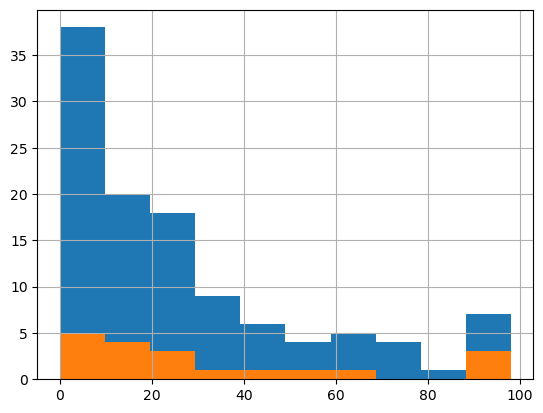

In [66]:
list_cal = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.group == "Group_3"].index.tolist()

estreams_attributes_clipped_filters.perm_high_regi.hist()
estreams_attributes_clipped_filters.loc[list_cal, ["area_estreams",'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_high_glob2',
       'perm_medium_glob2', 'perm_low_glob2']].sort_values("area_estreams").perm_high_regi.hist()

In [27]:
list_cal

['LU000008',
 'LU000005',
 'BEWA0106',
 'FR003280',
 'DERP2017',
 'DERP2031',
 'FR000125',
 'DERP2018',
 'DERP2022',
 'DERP2033',
 'FR003261',
 'FR003295',
 'FR003253',
 'FR003262',
 'DEBU1957',
 'DEBU1959',
 'FR000184']

In [28]:
list_cal = [
 'BEWA0106',
 'FR003280',
 'DERP2017',
 'DERP2031',
 'FR000125',
 'DERP2018',
 'DERP2022',
 'DERP2033',
 'FR003261',
 'FR003295',
 'FR003253',
 'FR003262',
 'DEBU1957',
 'DEBU1959',
 'FR000184']

In [29]:
# Drop duplicate basin_ids, keeping only the first occurrence
nse_results_cal_r_1_100_complete_cal = nse_results_cal_r_1_100_complete_cal.drop_duplicates(subset='basin', keep='first')
nse_results_cal_c_1_100_complete_cal = nse_results_cal_c_1_100_complete_cal.drop_duplicates(subset='basin', keep='first')
nse_results_cal_g_1_100_complete_cal = nse_results_cal_g_1_100_complete_cal.drop_duplicates(subset='basin', keep='first')

In [30]:
data_diff_cal_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_c_1_100_complete_cal.nse)
data_diff_cal_complete["nse_rg"] = nse_results_cal_r_1_100_complete_cal.nse - nse_results_cal_g_1_100_complete_cal.nse

data_diff_cal_complete.index = nse_results_cal_c_1_100_complete_cal.basin

data_diff_cal_complete = data_diff_cal_complete.loc[~data_diff_cal_complete.index.isin(list_cal)]

data_diff_cal_complete["nse_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete["nse_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete["slope_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete["slope_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete["slope_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete = data_diff_cal_complete[data_diff_cal_complete.nse_r1 > -10.0]
data_diff_cal_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.456506,-0.061122,0.647662,0.191156,0.708784,NaN,NaN,NaN,0.549133,0.656425,...,0.772178,0.845276,2.305895,2.488122,2.873824,2.278937,127.384615,139.538462,162.846154,140.000000
LU000010,0.353002,-0.081971,0.676355,0.323353,0.758326,NaN,NaN,NaN,0.618760,0.660051,...,0.891185,0.947367,1.430667,2.560856,2.847040,2.351894,130.615385,138.230769,156.615385,138.769231
LU000001,0.058081,0.047816,0.857489,0.799409,0.809673,NaN,NaN,NaN,0.546850,0.555801,...,1.315464,1.230787,3.860265,2.787193,2.652133,2.524674,121.615385,127.769231,134.692308,133.615385
DERP2028,0.098736,-0.070710,0.721993,0.623257,0.792703,0.733627,0.508446,0.805020,0.591229,0.722529,...,1.010388,0.999333,2.249833,2.203902,2.347887,2.408301,131.461538,146.576923,150.153846,139.576923
FR000183,0.117096,0.032927,0.417184,0.300088,0.384258,NaN,NaN,NaN,0.726346,0.692325,...,1.176979,1.142583,2.204864,2.483371,2.482256,2.646619,147.250000,142.541667,145.500000,137.916667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DERP2007,0.077257,0.009621,0.804426,0.727168,0.794804,0.846831,0.643792,0.735681,0.500914,0.612332,...,1.075410,1.055497,2.915571,2.539640,2.570211,2.248077,124.884615,135.538462,141.730769,141.846154
FR003271,0.170412,-0.011450,0.709455,0.539043,0.720904,NaN,NaN,NaN,0.543269,0.582374,...,0.618340,0.687367,2.584565,2.844545,2.673952,2.505987,124.560000,132.600000,150.280000,136.880000
FR003301,0.132887,-0.000911,0.809057,0.676170,0.809968,NaN,NaN,NaN,0.540766,0.632532,...,0.928855,0.938399,2.879739,2.643401,2.524358,2.473864,128.187500,136.250000,146.750000,137.750000


In [31]:
data_diff_cal_complete.iloc[0:10]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.456506,-0.061122,0.647662,0.191156,0.708784,NaN,NaN,NaN,0.549133,0.656425,...,0.772178,0.845276,2.305895,2.488122,2.873824,2.278937,127.384615,139.538462,162.846154,140.000000
LU000010,0.353002,-0.081971,0.676355,0.323353,0.758326,NaN,NaN,NaN,0.618760,0.660051,...,0.891185,0.947367,1.430667,2.560856,2.847040,2.351894,130.615385,138.230769,156.615385,138.769231
LU000001,0.058081,0.047816,0.857489,0.799409,0.809673,NaN,NaN,NaN,0.546850,0.555801,...,1.315464,1.230787,3.860265,2.787193,2.652133,2.524674,121.615385,127.769231,134.692308,133.615385
DERP2028,0.098736,-0.070710,0.721993,0.623257,0.792703,0.733627,0.508446,0.805020,0.591229,0.722529,...,1.010388,0.999333,2.249833,2.203902,2.347887,2.408301,131.461538,146.576923,150.153846,139.576923
FR000183,0.117096,0.032927,0.417184,0.300088,0.384258,NaN,NaN,NaN,0.726346,0.692325,...,1.176979,1.142583,2.204864,2.483371,2.482256,2.646619,147.250000,142.541667,145.500000,137.916667
DERP2008,0.080404,0.031860,0.765363,0.684959,0.733502,0.768159,0.591976,0.570638,0.463201,0.592366,...,1.037321,1.025369,3.555971,2.651921,2.669201,2.249849,120.884615,133.807692,141.115385,141.923077
FR000137,0.068154,0.000492,0.757132,0.688978,0.756641,NaN,NaN,NaN,0.507948,0.583430,...,1.026222,1.018411,2.966331,2.731488,2.385721,2.380136,124.304348,133.695652,141.652174,137.608696
FR003294,0.072466,0.001684,0.660778,0.588312,0.659093,NaN,NaN,NaN,0.516919,0.560409,...,0.788428,0.820867,2.515494,2.875872,2.486855,2.458593,129.095238,134.809524,147.428571,139.809524
FR000185,0.091283,-0.028847,0.399692,0.308409,0.428539,NaN,NaN,NaN,0.541713,0.704657,...,1.214931,1.194557,3.206302,2.342660,2.393955,2.585774,145.277778,149.388889,151.722222,144.833333


In [32]:
data_diff_cal_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,0.380781,-0.500384,-0.748396,-0.512011,-0.962321,-0.971340,-0.948270,0.333317,0.415098,...,-0.421342,-0.398384,-0.419683,-0.218960,0.283570,-0.098729,0.313605,0.423609,0.638258,0.284316
nse_rg,0.380781,1.000000,-0.583677,-0.586142,-0.760098,-0.891177,-0.880362,-0.954344,0.170637,0.144841,...,-0.018114,-0.037614,0.051564,-0.155661,-0.183467,0.113203,0.333208,0.170098,-0.075400,0.082516
nse_r1,-0.500384,-0.583677,1.000000,0.948732,0.971287,0.977138,0.969379,0.976428,-0.418132,-0.365030,...,0.129312,0.117003,0.277569,0.188803,-0.019183,-0.337377,-0.630964,-0.456064,-0.282658,-0.097209
nse_c1,-0.748396,-0.586142,0.948732,1.000000,0.930981,0.983419,0.980932,0.978440,-0.441997,-0.431174,...,0.252881,0.235071,0.365848,0.224571,-0.118220,-0.222406,-0.597842,-0.504019,-0.449543,-0.178264
nse_g1,-0.512011,-0.760098,0.971287,0.930981,1.000000,0.968669,0.959780,0.988400,-0.384615,-0.334561,...,0.108792,0.104655,0.207022,0.196702,0.038404,-0.303162,-0.602572,-0.414814,-0.204111,-0.101971
nse_bfi_r1,-0.962321,-0.891177,0.977138,0.983419,0.968669,1.000000,0.995300,0.980116,-0.603496,-0.586929,...,0.279028,0.259975,0.523625,0.451103,0.257068,-0.406648,-0.731134,-0.629013,-0.547257,-0.023459
nse_bfi_c1,-0.971340,-0.880362,0.969379,0.980932,0.959780,0.995300,1.000000,0.973558,-0.627297,-0.609931,...,0.325057,0.304978,0.548264,0.474135,0.270571,-0.388313,-0.749713,-0.646649,-0.579362,-0.038628
nse_bfi_g1,-0.948270,-0.954344,0.976428,0.978440,0.988400,0.980116,0.973558,1.000000,-0.494888,-0.472723,...,0.248425,0.232612,0.384165,0.354363,0.156266,-0.325642,-0.642759,-0.537468,-0.456135,-0.090812
bfi_obs,0.333317,0.170637,-0.418132,-0.441997,-0.384615,-0.603496,-0.627297,-0.494888,1.000000,0.610321,...,0.098236,0.100287,-0.736398,-0.491458,-0.171266,0.486040,0.835274,0.459295,0.061816,-0.158428
bfi_r1,0.415098,0.144841,-0.365030,-0.431174,-0.334561,-0.586929,-0.609931,-0.472723,0.610321,1.000000,...,-0.216932,-0.228570,-0.575339,-0.872290,-0.372307,0.163727,0.633130,0.820236,0.296223,0.209651


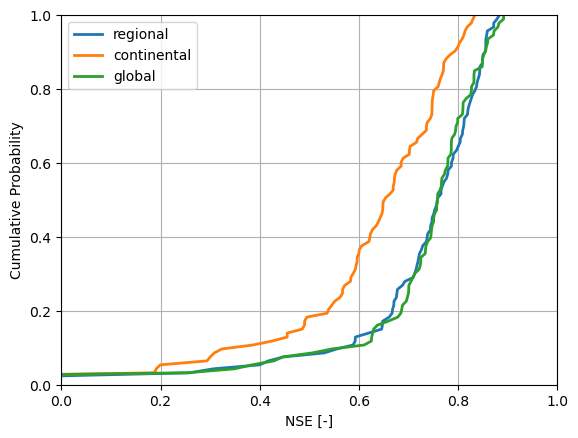

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

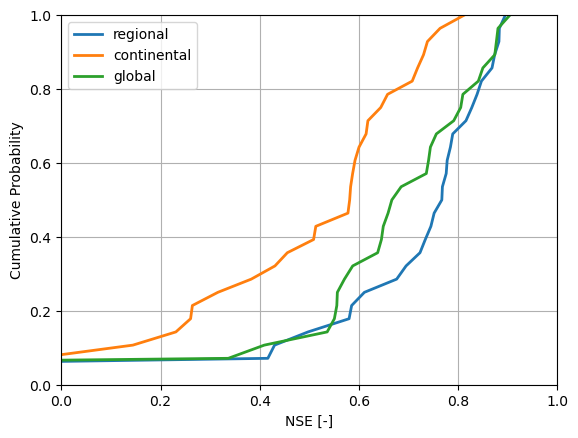

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [35]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_regi_Group_3"], perm_areas_model = perm_areas)
output_continental_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_cont_Group_3"], perm_areas_model = perm_areascontinental)
output_global_val = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_glob_Group_3"], perm_areas_model = perm_areasglobal)

In [36]:
path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_regi_Group_3_2"], perm_areas_model = perm_areas)
output_continental_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_cont_Group_3_2"], perm_areas_model = perm_areascontinental)
output_global_0115 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = all_param_dicts["best_params_glob_Group_3_2"], perm_areas_model = perm_areasglobal)

In [37]:
output_regional_val_c = {
    key: [np.concatenate([output_regional_val[key][0], output_regional_0115[key][0]])]
    for key in output_regional_0115
    if key in output_regional_val  # ensures keys match
}

output_continental_val_c = {
    key: [np.concatenate([output_continental_val[key][0], output_continental_0115[key][0]])]
    for key in output_continental_val
    if key in output_continental_0115  # ensures keys match
}

output_global_val_c = {
    key: [np.concatenate([output_global_val[key][0], output_global_0115[key][0]])]
    for key in output_global_val
    if key in output_global_0115  # ensures keys match
}

In [38]:
nse_results_cal_r_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c, observations_cal, quality_masks_cal)

In [39]:
nse_results_cal_c_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c, observations_cal, quality_masks_cal)

In [40]:
nse_results_cal_g_1_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c, observations_cal, quality_masks_cal)

In [248]:
estreams_attributes_clipped_filters.loc[list_cal, ["area_estreams",'perm_high_regi',
       'perm_medium_regi', 'perm_low_regi', 'perm_high_glob2',
       'perm_medium_glob2', 'perm_low_glob2']].sort_values("area_estreams")

,area_estreams,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,
DERP2006,54.000,4.0,11.0,85.0,0.0,100.0,0.0
FR000124,71.180,3.0,0.0,97.0,0.0,22.0,78.0
BEWA0067,101.033,2.0,0.0,98.0,64.0,36.0,0.0
FR000144,117.784,92.0,0.0,8.0,83.0,5.0,12.0
FR000144,117.784,92.0,0.0,8.0,83.0,5.0,12.0
FR000144,117.784,92.0,0.0,8.0,83.0,5.0,12.0
FR000169,149.296,10.0,90.0,0.0,0.0,100.0,0.0
DERP2029,192.000,73.0,22.0,5.0,75.0,25.0,0.0
FR000153,299.413,76.0,24.0,0.0,56.0,44.0,0.0


In [41]:
# Drop duplicate basin_ids, keeping only the first occurrence
nse_results_cal_r_1_100_complete_val = nse_results_cal_r_1_100_complete_val.drop_duplicates(subset='basin', keep='first')
nse_results_cal_c_1_100_complete_val = nse_results_cal_c_1_100_complete_val.drop_duplicates(subset='basin', keep='first')
nse_results_cal_g_1_100_complete_val = nse_results_cal_g_1_100_complete_val.drop_duplicates(subset='basin', keep='first')

In [42]:
data_diff_val_complete = pd.DataFrame(data=nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_c_1_100_complete_val.nse)
data_diff_val_complete["nse_rg"] = nse_results_cal_r_1_100_complete_val.nse - nse_results_cal_g_1_100_complete_val.nse

data_diff_val_complete.index = nse_results_cal_c_1_100_complete_val.basin

data_diff_val_complete = data_diff_val_complete.loc[~data_diff_val_complete.index.isin(list_cal)]

data_diff_val_complete["nse_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete["nse_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete["nse_bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete["nse_bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete["bfi_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete["bfi_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete["bfi_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete["qmean_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete["qmean_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete["qmean_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete["slope_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete["slope_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete["slope_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete["hfd_obs"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete["hfd_r1"] = nse_results_cal_r_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_c1"] = nse_results_cal_c_1_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete["hfd_g1"] = nse_results_cal_g_1_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete = data_diff_val_complete[data_diff_val_complete.nse_r1 > -10.0]
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.137331,-0.005360,0.649228,0.511897,0.654588,NaN,NaN,NaN,0.549133,0.653050,...,0.727274,0.726194,2.305895,2.031385,1.912631,2.157341,127.384615,137.923077,142.538462,137.769231
LU000010,0.101124,-0.006085,0.719024,0.617899,0.725109,NaN,NaN,NaN,0.618760,0.651290,...,0.814593,0.813042,1.430667,2.106981,2.048181,2.279769,130.615385,136.461538,141.000000,136.923077
LU000001,-0.026572,0.019834,0.807188,0.833760,0.787354,NaN,NaN,NaN,0.546850,0.586626,...,1.053686,1.052642,3.860265,2.256578,2.451571,2.257604,121.615385,132.000000,130.307692,136.230769
DERP2028,0.025377,-0.074582,0.694971,0.669594,0.769553,0.622528,0.618466,0.753086,0.591229,0.727920,...,1.034632,1.013296,2.249833,2.239376,2.336317,2.474207,131.461538,144.000000,145.846154,138.807692
FR000183,0.042421,0.047183,0.448812,0.406391,0.401629,NaN,NaN,NaN,0.726346,0.696237,...,1.176543,1.134307,2.204864,2.303124,2.314521,2.492847,147.250000,141.416667,144.500000,137.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DERP2007,0.017690,0.008969,0.779276,0.761586,0.770307,0.800408,0.752931,0.668422,0.500914,0.612040,...,1.107061,1.070499,2.915571,2.573511,2.510569,2.374868,124.884615,134.769231,136.846154,140.884615
FR003271,0.034446,-0.027623,0.666092,0.631646,0.693715,NaN,NaN,NaN,0.543269,0.588597,...,0.657599,0.697214,2.584565,2.709584,2.498835,2.440475,124.560000,132.560000,144.360000,136.800000
FR003301,0.017948,-0.010220,0.791647,0.773699,0.801867,NaN,NaN,NaN,0.540766,0.637490,...,0.902564,0.885339,2.879739,2.369562,2.259615,2.355082,128.187500,135.875000,142.000000,137.250000


In [44]:
data_diff_val_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,0.651360,-0.547901,-0.715720,-0.618405,-0.929216,-0.947996,-0.951625,0.329668,0.466324,...,-0.077535,-0.079077,-0.379105,-0.187020,-0.037575,0.108711,0.355307,0.360058,0.344694,0.074554
nse_rg,0.651360,1.000000,-0.627704,-0.692288,-0.776682,-0.850008,-0.884279,-0.940972,0.247607,0.235764,...,-0.094592,-0.095341,-0.081101,-0.172294,0.072800,0.050544,0.393144,0.276535,0.111369,0.137508
nse_r1,-0.547901,-0.627704,1.000000,0.976375,0.977868,0.969754,0.979536,0.974943,-0.426733,-0.403313,...,0.078181,0.079147,0.258995,0.127059,-0.016194,-0.324659,-0.642230,-0.453458,-0.412196,-0.046275
nse_c1,-0.715720,-0.692288,0.976375,1.000000,0.976110,0.970100,0.982318,0.979801,-0.441413,-0.457160,...,0.085297,0.086502,0.314147,0.154383,-0.003813,-0.299122,-0.627943,-0.471574,-0.433157,-0.057890
nse_g1,-0.618405,-0.776682,0.977868,0.976110,1.000000,0.954479,0.971978,0.986053,-0.411845,-0.389711,...,0.088684,0.089667,0.231366,0.149118,-0.032669,-0.276286,-0.625332,-0.441244,-0.363465,-0.074401
nse_bfi_r1,-0.929216,-0.850008,0.969754,0.970100,0.954479,1.000000,0.994887,0.969964,-0.626947,-0.640877,...,0.291490,0.276635,0.565014,0.563899,0.056964,-0.484059,-0.751187,-0.679615,-0.683207,0.006065
nse_bfi_c1,-0.947996,-0.884279,0.979536,0.982318,0.971978,0.994887,1.000000,0.983572,-0.602369,-0.588035,...,0.283508,0.269030,0.525393,0.512341,0.020893,-0.451866,-0.726791,-0.633231,-0.643642,-0.011671
nse_bfi_g1,-0.951625,-0.940972,0.974943,0.979801,0.986053,0.969964,0.983572,1.000000,-0.497558,-0.485857,...,0.261421,0.249227,0.394364,0.410303,-0.104243,-0.382305,-0.645376,-0.564998,-0.550033,-0.093284
bfi_obs,0.329668,0.247607,-0.426733,-0.441413,-0.411845,-0.626947,-0.602369,-0.497558,1.000000,0.590953,...,0.122159,0.114265,-0.736398,-0.326867,-0.095292,0.354561,0.835274,0.363255,0.180525,-0.215152
bfi_r1,0.466324,0.235764,-0.403313,-0.457160,-0.389711,-0.640877,-0.588035,-0.485857,0.590953,1.000000,...,-0.244607,-0.258273,-0.533951,-0.633113,-0.249658,0.050767,0.625052,0.753815,0.483439,0.196439


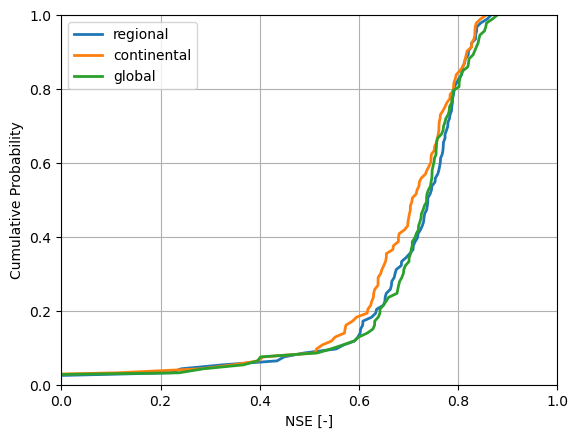

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

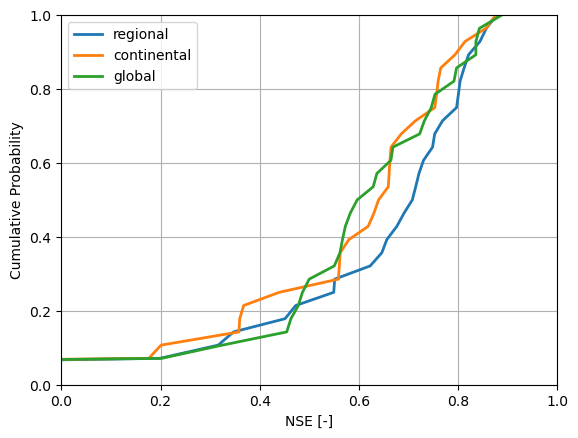

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [47]:
data_diff_val_complete.corr()

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
nse,1.000000,0.651360,-0.547901,-0.715720,-0.618405,-0.929216,-0.947996,-0.951625,0.329668,0.466324,...,-0.077535,-0.079077,-0.379105,-0.187020,-0.037575,0.108711,0.355307,0.360058,0.344694,0.074554
nse_rg,0.651360,1.000000,-0.627704,-0.692288,-0.776682,-0.850008,-0.884279,-0.940972,0.247607,0.235764,...,-0.094592,-0.095341,-0.081101,-0.172294,0.072800,0.050544,0.393144,0.276535,0.111369,0.137508
nse_r1,-0.547901,-0.627704,1.000000,0.976375,0.977868,0.969754,0.979536,0.974943,-0.426733,-0.403313,...,0.078181,0.079147,0.258995,0.127059,-0.016194,-0.324659,-0.642230,-0.453458,-0.412196,-0.046275
nse_c1,-0.715720,-0.692288,0.976375,1.000000,0.976110,0.970100,0.982318,0.979801,-0.441413,-0.457160,...,0.085297,0.086502,0.314147,0.154383,-0.003813,-0.299122,-0.627943,-0.471574,-0.433157,-0.057890
nse_g1,-0.618405,-0.776682,0.977868,0.976110,1.000000,0.954479,0.971978,0.986053,-0.411845,-0.389711,...,0.088684,0.089667,0.231366,0.149118,-0.032669,-0.276286,-0.625332,-0.441244,-0.363465,-0.074401
nse_bfi_r1,-0.929216,-0.850008,0.969754,0.970100,0.954479,1.000000,0.994887,0.969964,-0.626947,-0.640877,...,0.291490,0.276635,0.565014,0.563899,0.056964,-0.484059,-0.751187,-0.679615,-0.683207,0.006065
nse_bfi_c1,-0.947996,-0.884279,0.979536,0.982318,0.971978,0.994887,1.000000,0.983572,-0.602369,-0.588035,...,0.283508,0.269030,0.525393,0.512341,0.020893,-0.451866,-0.726791,-0.633231,-0.643642,-0.011671
nse_bfi_g1,-0.951625,-0.940972,0.974943,0.979801,0.986053,0.969964,0.983572,1.000000,-0.497558,-0.485857,...,0.261421,0.249227,0.394364,0.410303,-0.104243,-0.382305,-0.645376,-0.564998,-0.550033,-0.093284
bfi_obs,0.329668,0.247607,-0.426733,-0.441413,-0.411845,-0.626947,-0.602369,-0.497558,1.000000,0.590953,...,0.122159,0.114265,-0.736398,-0.326867,-0.095292,0.354561,0.835274,0.363255,0.180525,-0.215152
bfi_r1,0.466324,0.235764,-0.403313,-0.457160,-0.389711,-0.640877,-0.588035,-0.485857,0.590953,1.000000,...,-0.244607,-0.258273,-0.533951,-0.633113,-0.249658,0.050767,0.625052,0.753815,0.483439,0.196439


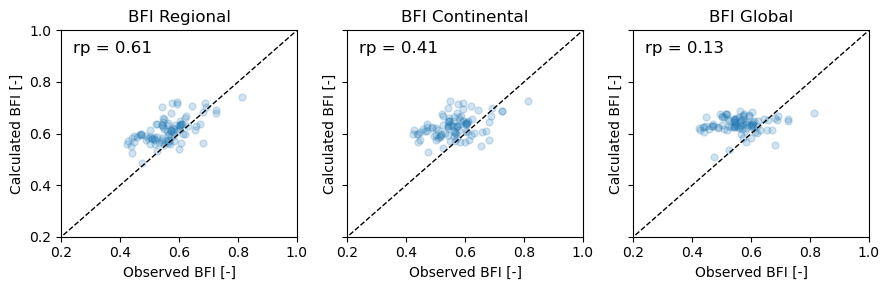

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_cal_complete["bfi_obs"]
    y = data_diff_cal_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_cal_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

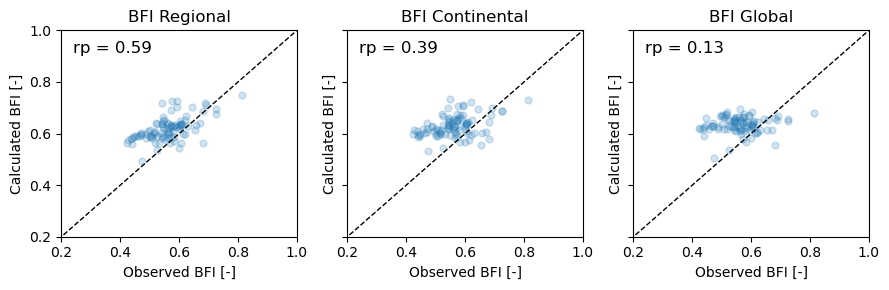

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["bfi_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

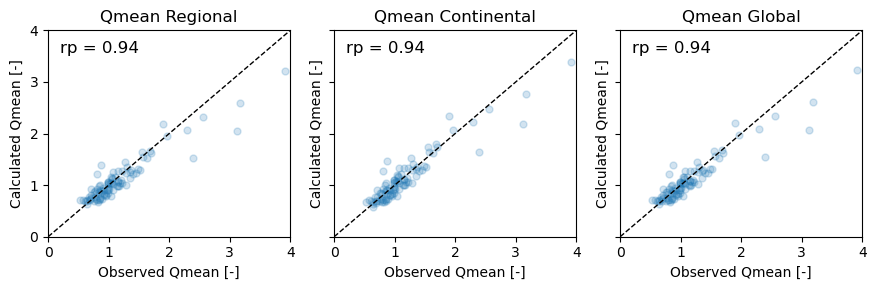

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["qmean_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

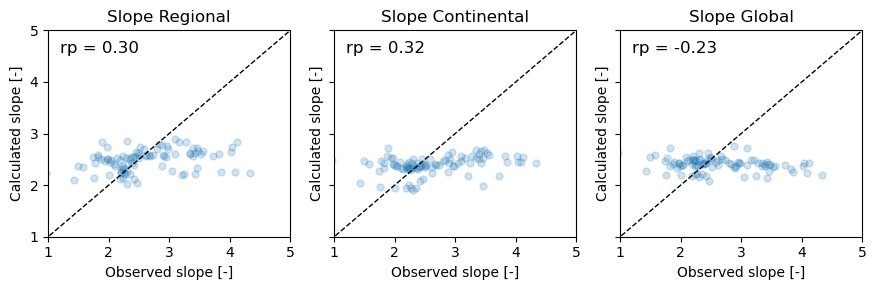

In [51]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["slope_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed slope [-]")
    ax.set_ylabel("Calculated slope [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

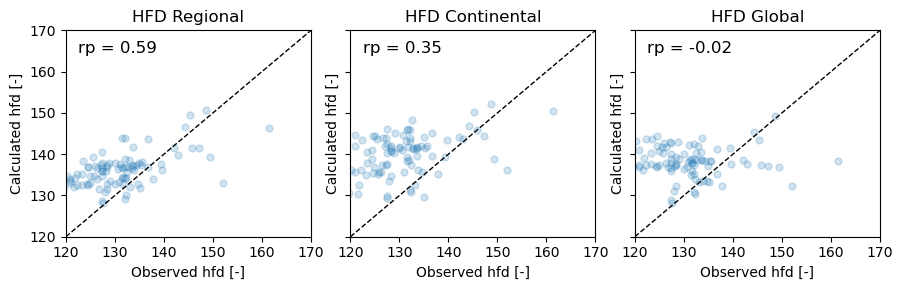

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete["hfd_obs"]
    y = data_diff_val_complete[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed hfd [-]")
    ax.set_ylabel("Calculated hfd [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

In [259]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin=="BEWA0066"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
89,Reuland,BEWA0066,0.835024,0.514795,0.571254,0.844145,1.238351,1.175397,3.347668,2.509014,125.769231,133.384615


In [260]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse<0]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
16,A6232010,FR000144,-0.142164,0.678912,0.830451,NaN,1.348492,1.110966,2.28005,1.435323,178.444444,166.888889
23,A6232010,FR000144,-0.142164,0.678912,0.830451,NaN,1.348492,1.110966,2.28005,1.435323,178.444444,166.888889
65,A6232010,FR000144,-0.142164,0.678912,0.830451,NaN,1.348492,1.110966,2.28005,1.435323,178.444444,166.888889


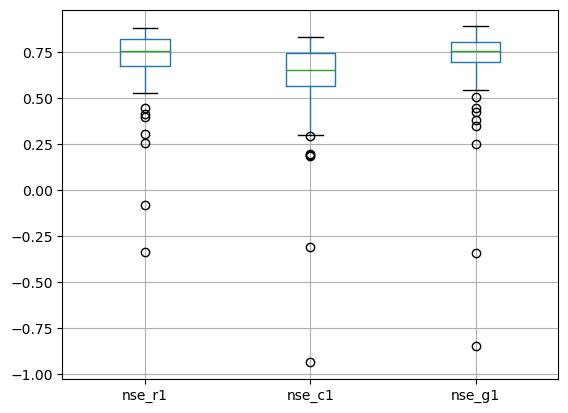

In [53]:
import matplotlib.pyplot as plt

# Plot both columns side by side
data_diff_cal_complete.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()


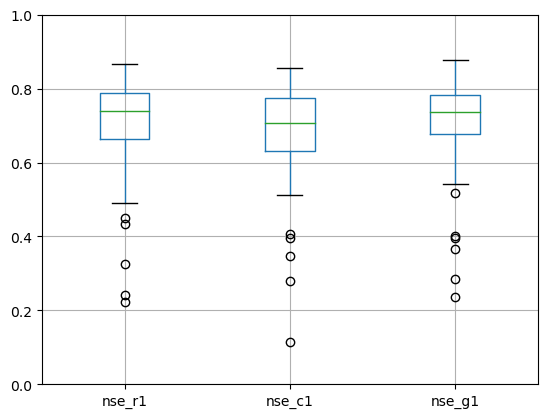

In [54]:
import matplotlib.pyplot as plt

# Plot both columns side by side
ax = data_diff_val_complete.boxplot(column=["nse_r1", "nse_c1", "nse_g1"])

# Set y-axis limits from 0 to 1
plt.ylim(0, 1)

# Show the plot
plt.show()

In [264]:
data_diff_val_complete[data_diff_val_complete.nse_rg > 0.1]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000001,-0.000606,0.138521,0.832297,0.832903,0.693776,NaN,NaN,NaN,0.546850,0.563383,...,1.052637,1.058087,3.860265,2.506153,2.558768,2.007403,121.615385,128.769231,128.307692,144.076923
DERP2004,-0.002961,0.132353,0.797147,0.800107,0.664794,0.785507,0.788728,0.352053,0.500196,0.569607,...,1.267937,1.259837,3.097860,2.680594,2.812675,2.179208,125.730769,134.384615,132.961538,145.692308
LU000005,-0.003408,0.113642,0.818574,0.821982,0.704933,NaN,NaN,NaN,0.513152,0.581339,...,1.058089,1.066443,3.044633,2.479453,2.551511,2.007419,124.538462,134.461538,133.692308,145.538462
BEWA0106,-0.004061,0.238584,0.743312,0.747372,0.504728,NaN,NaN,NaN,0.496805,0.575029,...,1.072094,1.062276,4.063631,2.734345,2.806559,1.967005,127.000000,135.304348,134.565217,153.000000
LU000011,-0.000670,0.136085,0.825940,0.826610,0.689854,NaN,NaN,NaN,0.562102,0.601560,...,0.847753,0.857264,3.245834,2.474600,2.550235,1.858023,131.000000,134.538462,133.307692,149.153846
BEWA0107,0.010104,0.146095,0.738214,0.728110,0.592119,NaN,NaN,NaN,0.565063,0.559909,...,1.437849,1.405234,3.418299,2.756030,2.867114,2.025818,133.588235,139.529412,137.882353,152.470588
BEWA0119,-0.002147,0.168202,0.800626,0.802772,0.632424,NaN,NaN,NaN,0.508101,0.569458,...,1.338932,1.332949,3.336434,2.748282,2.860884,2.202330,123.266667,134.733333,133.333333,145.400000
DERP2013,0.327536,0.299026,0.147444,-0.180092,-0.151582,-0.595627,-1.076546,-1.111298,0.813898,0.826247,...,0.856028,0.859664,0.958560,1.667275,1.849752,1.978280,161.346154,160.653846,156.576923,150.961538
LU000015,-0.002033,0.136069,0.792632,0.794665,0.656563,NaN,NaN,NaN,0.516853,0.584291,...,0.918876,0.926796,4.331634,2.488584,2.557074,1.897082,121.769231,130.923077,130.153846,146.384615


In [166]:
data_diff_val_complete[data_diff_val_complete.nse_rg < 0.1]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.264234,0.036756,0.660972,0.396738,0.624217,NaN,NaN,NaN,0.549133,0.660535,...,0.721674,0.741830,2.305895,2.128841,1.499634,2.885730,127.384615,139.153846,158.153846,129.846154
LU000006,0.005918,0.048308,0.831386,0.825468,0.783078,NaN,NaN,NaN,0.572308,0.591352,...,0.793635,0.807310,2.414131,2.457609,2.326643,2.035233,127.461538,132.384615,135.230769,141.846154
LU000007,0.006225,0.046448,0.801900,0.795675,0.755452,NaN,NaN,NaN,0.582038,0.608476,...,0.716127,0.732814,2.179299,2.408715,2.177549,2.711614,135.307692,134.307692,138.153846,131.076923
LU000014,-0.001559,0.083590,0.766723,0.768281,0.683133,NaN,NaN,NaN,0.591075,0.601572,...,0.701515,0.718787,1.750158,2.441882,2.171381,2.855294,134.307692,134.076923,138.461538,130.153846
DERP2006,0.035505,-0.006183,0.797974,0.762469,0.804157,0.825276,0.761328,0.814084,0.439622,0.538244,...,1.300956,1.305247,4.017057,2.917951,2.702550,3.129960,122.230769,133.153846,134.769231,133.461538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DERP2007,0.012031,-0.005593,0.803458,0.791427,0.809051,0.862606,0.836465,0.808617,0.500914,0.576713,...,1.057971,1.066305,2.915571,2.719679,2.615813,3.018365,124.884615,133.115385,133.807692,132.153846
FR003271,0.000634,0.033836,0.706392,0.705758,0.672556,NaN,NaN,NaN,0.543269,0.559275,...,0.686746,0.700314,2.584565,3.116544,2.942727,3.333442,124.560000,129.320000,130.120000,125.640000
FR003301,0.002395,0.009157,0.814401,0.812006,0.805244,NaN,NaN,NaN,0.540766,0.627050,...,0.875334,0.887214,2.879739,2.575458,2.473024,2.563044,128.187500,135.062500,135.625000,134.062500


In [167]:
data_diff_val_complete.loc[["FR000174"]]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
FR000174,-0.003593,0.015694,0.607899,0.611492,0.592205,NaN,NaN,NaN,0.437861,0.529378,...,0.703418,0.71698,3.730071,3.203214,3.251782,3.15053,117.923077,132.076923,132.0,132.846154


<Axes: >

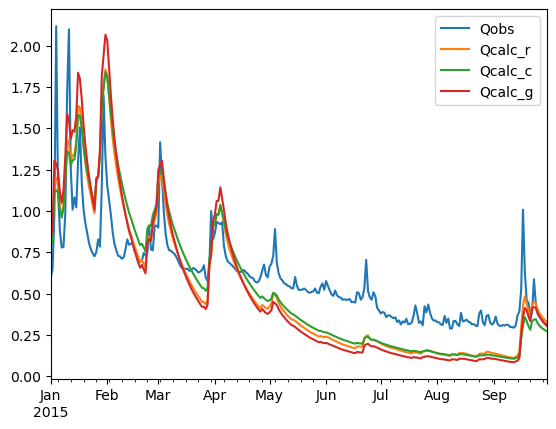

In [55]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2013"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2015"].plot()

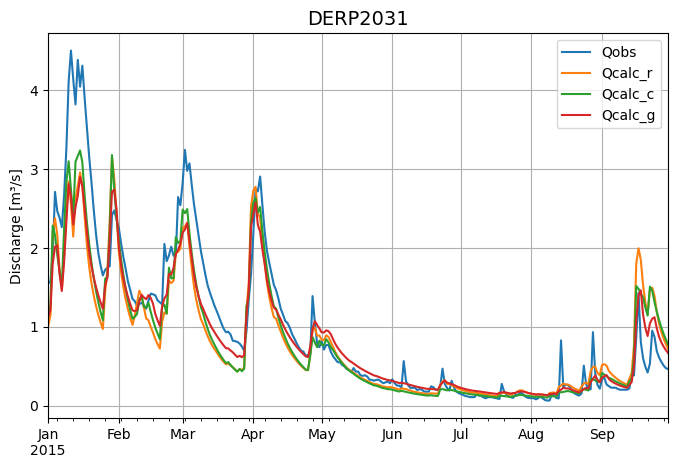

In [56]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DERP2031"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

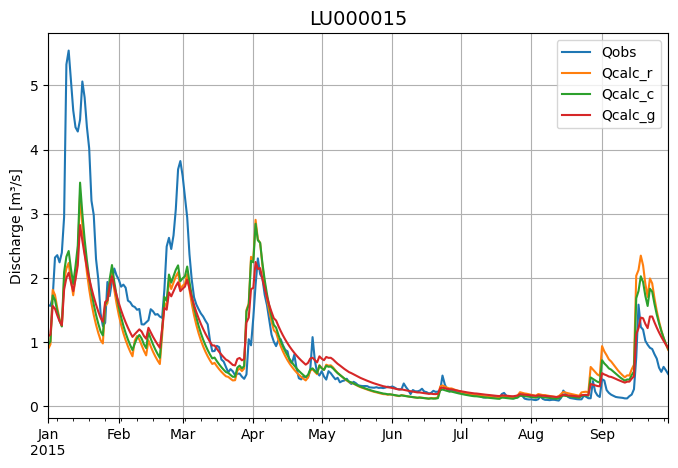

In [57]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000015"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

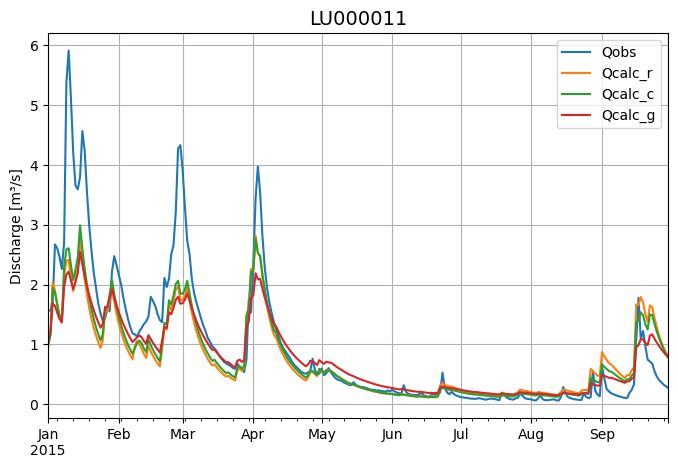

In [58]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000011"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

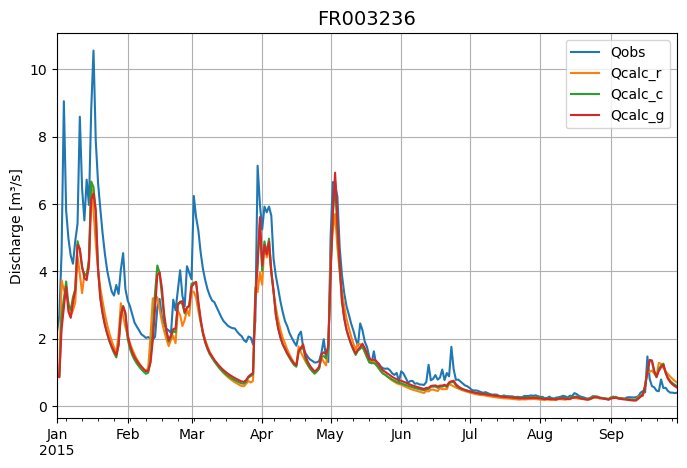

In [59]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003236"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

<Axes: >

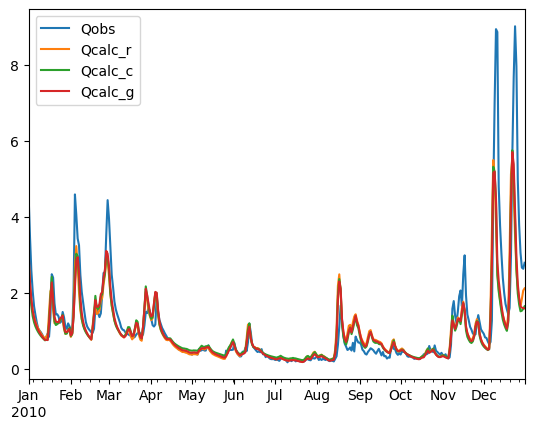

In [60]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="DEBU1956"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

<Axes: >

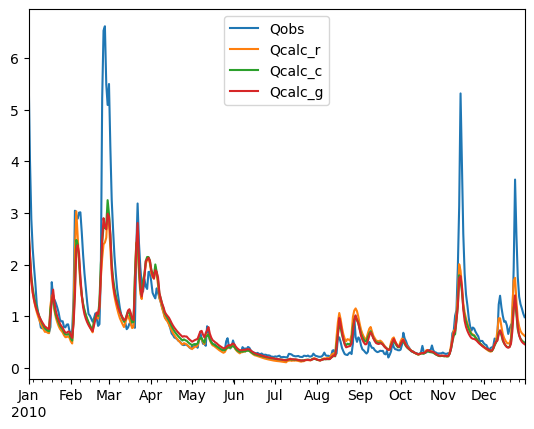

In [61]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="LU000017"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

Qtimeseries.loc["2010"].plot()

In [62]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
8,A9021050,FR000185,0.287135,0.552725,0.745738,NaN,0.774233,1.179506,3.438700,1.965252,157.500000,163.000000
16,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
23,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
36,Le Woigot Ã Briey,FR003280,0.493093,0.689765,0.544019,NaN,1.295303,0.884625,3.038034,3.050208,138.076923,133.307692
65,A6232010,FR000144,-0.489820,0.678912,0.758575,NaN,1.348492,1.181155,2.280050,2.096348,178.444444,152.777778
70,Le Canner Ã KÅ“nigsmacker,FR003288,0.417412,0.588279,0.632877,NaN,0.492836,0.645429,1.896325,2.567747,128.846154,137.384615
76,Contwig,DERP2013,-0.488618,0.814145,0.778640,-1.972549,0.650233,0.793763,0.911240,2.230657,161.615385,153.923077
83,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR003259,0.194456,0.582905,0.712927,NaN,0.835544,1.307601,2.004998,2.121848,143.285714,148.285714
98,La Meurthe Ã Fraize,FR003250,0.354904,0.683506,0.566194,NaN,2.122664,1.538537,1.657028,2.608849,154.250000,133.000000


In [292]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR000183"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
51,A9001050,FR000183,0.813653,0.701242,0.744249,NaN,1.099647,1.045212,1.964987,1.973349,146.272727,149.363636


In [293]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003252"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
66,La Meurthe Ã Azerailles et Ã Baccarat,FR003252,0.746247,0.68354,0.682204,NaN,1.860452,1.575774,2.360902,2.057833,153.833333,147.666667


In [294]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == "FR003254"]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
68,La Vezouze Ã BlÃ¢mont et Ã FrÃ©monville,FR003254,0.731087,0.679523,0.748233,NaN,1.230142,0.987262,2.007317,2.101612,144.0,153.666667


In [79]:
nse_results_cal_c_1_100[nse_results_cal_c_1_100.nse < 0.5]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
2,Martelange,BEWA0087,-20.952601,0.715474,0.541796,NaN,0.196649,1.271732,1.740044,3.133023,149.666667,123.500000
18,Contwig,DERP2013,0.284077,0.814145,0.903759,-0.571054,0.650233,0.758876,0.911240,1.011156,161.615385,178.307692
21,Saarburg,DERP2016,0.312854,0.670428,0.494655,-0.708736,0.790717,0.738667,1.843940,4.011947,141.615385,127.461538
29,Eisenschmitt,DERP2028,0.322533,0.601355,0.895222,-0.036490,0.955417,0.844708,2.127521,1.001812,133.000000,176.461538
30,Dreis,DERP2029,0.437715,0.581470,0.864318,-0.350848,0.719485,0.764893,2.157646,1.117771,133.615385,169.923077
38,A4333010,FR000132,0.357028,0.663813,0.523920,NaN,1.738141,2.182535,1.942057,2.880786,134.636364,122.818182
43,A6232010,FR000144,-0.120584,0.678912,0.789053,NaN,1.348492,1.174152,2.280050,1.358923,178.444444,159.222222
52,A9013050,FR000184,0.494479,0.768679,0.899653,NaN,1.281813,1.146868,1.627801,1.078761,149.666667,175.666667
53,A9021050,FR000185,0.161288,0.552725,0.819895,NaN,0.774233,1.132219,3.438700,1.184193,157.500000,173.833333
64,La Meurthe Ã Fraize,FR003250,0.239730,0.683506,0.539023,NaN,2.122664,1.532101,1.657028,2.899255,154.250000,129.750000


In [63]:
len(nse_results_cal_r_1_100_8801[nse_results_cal_r_1_100_8801.nse < 0.5])

13

In [64]:
len(nse_results_cal_c_1_100_8801[nse_results_cal_c_1_100_8801.nse < 0.5])

14

In [65]:
len(nse_results_cal_g_1_100_8801[nse_results_cal_g_1_100_8801.nse < 0.5])

12

In [179]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


In [83]:
nse_results_cal_r_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.352785
DERP2017    0.867801
DERP2011    0.819390
DERP2013    0.234303
DERP2007    0.856445
DERP2024    0.879439
FR003253    0.773447
FR003283    0.727192
FR003301    0.855149
DERP2003    0.885016
FR003265    0.902029
FR003272    0.880370
DEBU1958    0.902156
Name: nse, dtype: float64

In [84]:
nse_results_cal_c_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.486031
DERP2017    0.841313
DERP2011    0.780354
DERP2013    0.123369
DERP2007    0.820179
DERP2024    0.862515
FR003253    0.793678
FR003283    0.713177
FR003301    0.821363
DERP2003    0.854755
FR003265    0.896927
FR003272    0.877333
DEBU1958    0.889595
Name: nse, dtype: float64

In [85]:
nse_results_cal_g_1_100_8801.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.465567
DERP2017    0.730429
DERP2011    0.806612
DERP2013    0.141411
DERP2007    0.866385
DERP2024    0.876119
FR003253    0.808930
FR003283    0.731916
FR003301    0.838486
DERP2003    0.790638
FR003265    0.903852
FR003272    0.884194
DEBU1958    0.895964
Name: nse, dtype: float64

In [86]:
nse_results_cal_r_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.659844
DERP2017    0.838269
DERP2011    0.772581
DERP2013    0.176162
DERP2007    0.804265
DERP2024    0.835266
FR003253    0.765287
FR003283    0.759701
FR003301    0.821211
DERP2003    0.860527
FR003265    0.882589
FR003272    0.851035
DEBU1958    0.899955
Name: nse, dtype: float64

In [87]:
nse_results_cal_c_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.494479
DERP2017    0.806931
DERP2011    0.754340
DERP2013    0.284077
DERP2007    0.791043
DERP2024    0.836585
FR003253    0.755521
FR003283    0.778456
FR003301    0.852679
DERP2003    0.870758
FR003265    0.906480
FR003272    0.865265
DEBU1958    0.914803
Name: nse, dtype: float64

In [88]:
nse_results_cal_g_1_100.set_index("basin", inplace=False).loc[list_cal].nse

basin
FR000184    0.691362
DERP2017    0.750994
DERP2011    0.779291
DERP2013    0.108688
DERP2007    0.828013
DERP2024    0.833642
FR003253    0.793202
FR003283    0.758378
FR003301    0.818336
DERP2003    0.786225
FR003265    0.892816
FR003272    0.859693
DEBU1958    0.898294
Name: nse, dtype: float64

In [137]:
data_diff_val_complete[["lon", "lat"]] = network_estreams[["lon", "lat"]]
data_diff_val_complete

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,0.033513,0.295382,0.838430,0.804917,0.543048,NaN,NaN,NaN,0.515742,0.550943,...,3.400558,3.121880,2.554032,1.713252,126.294118,129.588235,134.941176,156.176471,6.151802,50.188258
BEWA0067,0.047152,0.236029,0.788691,0.741539,0.552662,NaN,NaN,NaN,0.446878,0.537480,...,3.527884,3.133557,2.543764,1.836960,123.437500,129.187500,137.500000,152.687500,6.263467,50.289277
BEWA0106,0.017845,0.413216,0.764083,0.746238,0.350867,NaN,NaN,NaN,0.496805,0.547966,...,4.063631,3.118763,2.623174,1.562442,127.000000,130.739130,134.869565,164.260870,6.150669,50.196522
BEWA0107,0.010444,0.303428,0.740081,0.729637,0.436653,NaN,NaN,NaN,0.565063,0.536219,...,3.418299,3.138160,2.724969,1.713870,133.588235,134.058824,138.647059,165.823529,6.153955,50.234494
BEWA0119,0.025248,0.267249,0.815924,0.790676,0.548675,NaN,NaN,NaN,0.508101,0.545023,...,3.336434,3.139372,2.679279,1.866495,123.266667,129.400000,133.333333,153.933333,6.141814,50.141935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,0.054974,0.467338,0.819813,0.764840,0.352475,NaN,NaN,NaN,0.516853,0.551345,...,4.331634,2.995448,2.226096,1.351069,121.769231,124.384615,132.461538,163.615385,6.091178,49.895421
LU000016,-0.038874,0.026691,0.636273,0.675147,0.609581,NaN,NaN,NaN,0.564940,0.522122,...,2.005883,3.044009,2.571448,3.110440,133.615385,126.000000,132.230769,127.230769,6.132266,49.620647
LU000017,0.031045,0.077578,0.860150,0.829105,0.782572,NaN,NaN,NaN,0.572433,0.591535,...,2.459555,2.591746,1.990153,1.716308,127.307692,129.461538,136.692308,144.000000,6.509851,49.785883


In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import geopandas as gpd

In [158]:
moselle=gpd.read_file(r"..\data\shps\moselle_delienation.shp")
rivers_moselle=gpd.read_file(r"..\data\shps\rivers_moselle.shp")

In [262]:
list_cal = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']


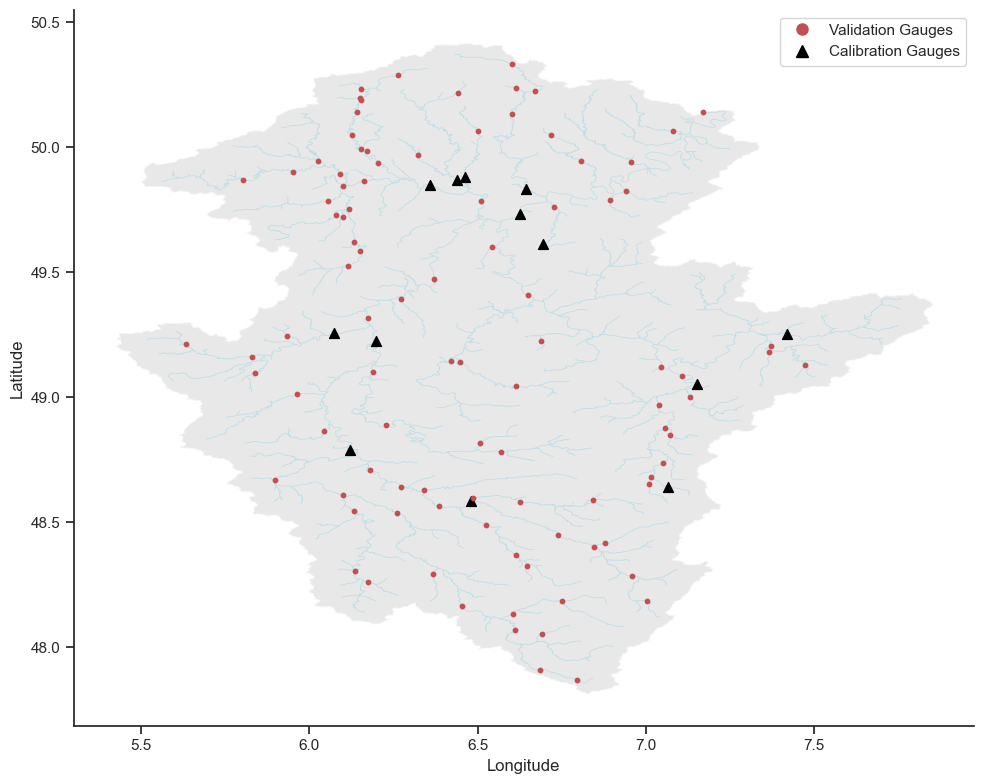

In [263]:
df = data_diff_val_complete.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
LU000018,0.165330,-0.005979,0.643927,0.478597,0.649906,NaN,NaN,NaN,0.549133,0.663651,...,0.747819,0.753208,2.305895,2.126032,1.752822,2.940732,127.384615,139.230769,146.230769,129.615385
LU000010,0.118536,0.074434,0.710777,0.592241,0.636343,NaN,NaN,NaN,0.618760,0.667081,...,0.834394,0.840603,1.430667,2.156746,1.903346,2.982150,130.615385,138.615385,143.692308,128.923077
LU000001,0.002910,0.160013,0.827942,0.825032,0.667929,NaN,NaN,NaN,0.546850,0.558409,...,1.070685,1.082947,3.860265,2.508516,2.444504,1.978572,121.615385,129.230769,129.000000,145.846154
DERP2028,0.004380,-0.076293,0.631966,0.627586,0.708260,0.578659,0.569747,0.699353,0.591229,0.771450,...,1.007220,0.990973,2.249833,2.012464,2.052597,2.119470,131.461538,152.653846,149.269231,147.115385
FR000183,0.009503,-0.001809,0.476467,0.466965,0.478277,NaN,NaN,NaN,0.726346,0.737001,...,1.129375,1.117234,2.204864,2.113599,2.233890,2.270498,147.250000,147.500000,143.791667,142.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DERP2007,0.000284,-0.009585,0.780389,0.780105,0.789974,0.813876,0.791860,0.771415,0.500914,0.615233,...,1.064938,1.048703,2.915571,2.503010,2.523587,2.837581,124.884615,136.423077,134.884615,135.923077
FR003271,-0.010294,0.015875,0.706475,0.716769,0.690601,NaN,NaN,NaN,0.543269,0.604438,...,0.705003,0.695529,2.584565,2.792069,2.574238,3.001353,124.560000,132.960000,134.040000,130.440000
FR003301,0.012553,-0.014131,0.782955,0.770402,0.797086,NaN,NaN,NaN,0.540766,0.653930,...,0.892364,0.888493,2.879739,2.441276,2.348354,2.595211,128.187500,137.562500,137.187500,134.687500


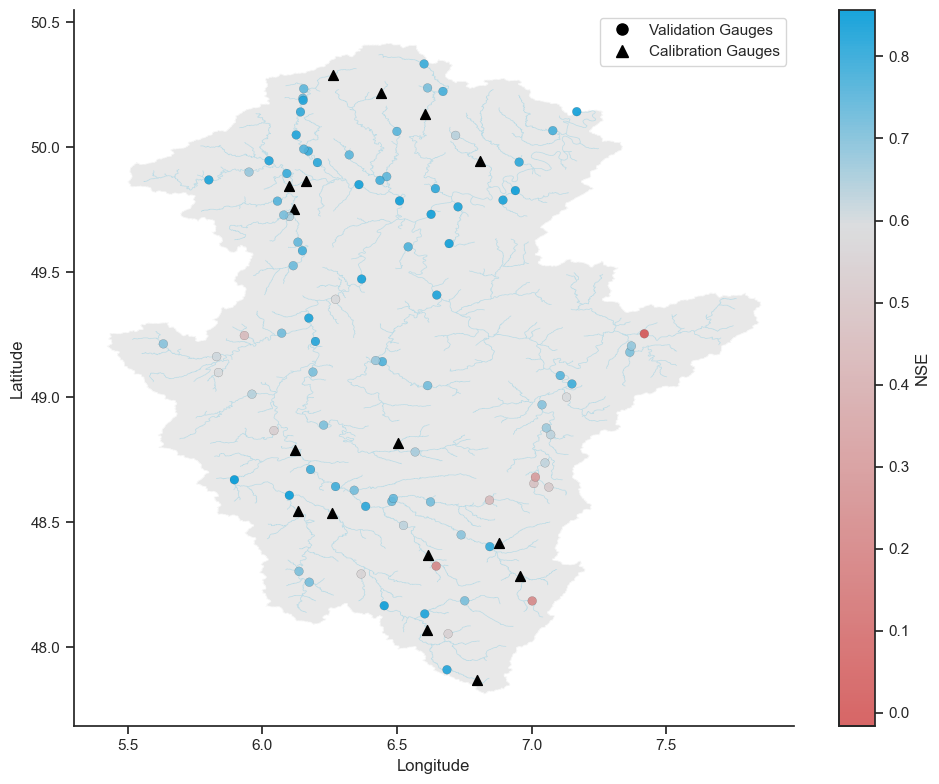

In [161]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_r1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


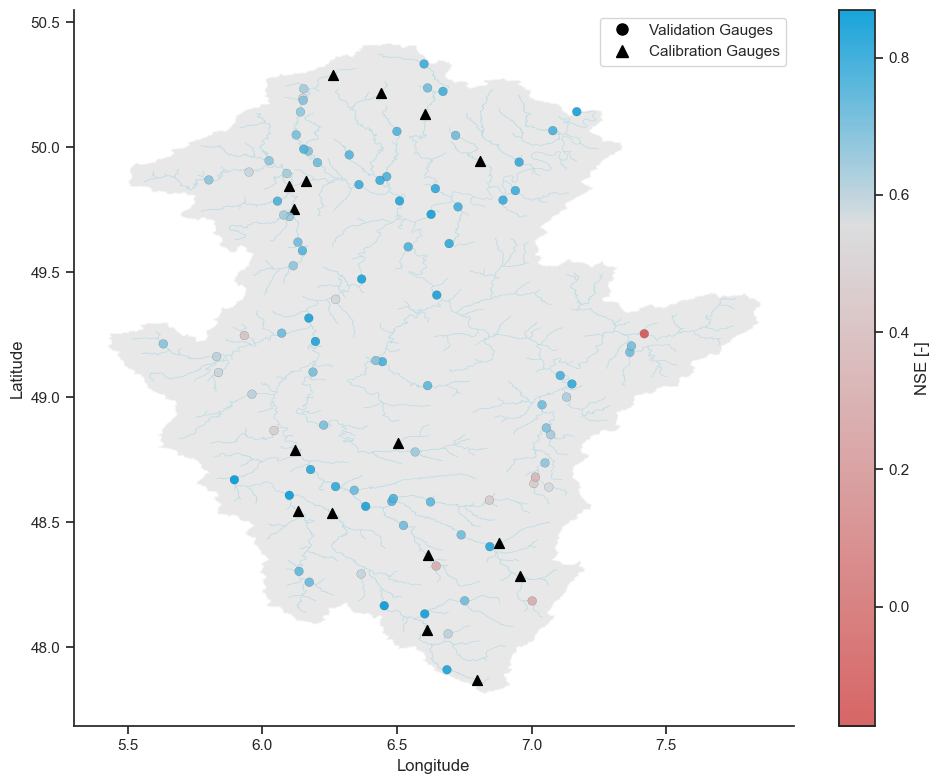

In [162]:

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_g1'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE [-]", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


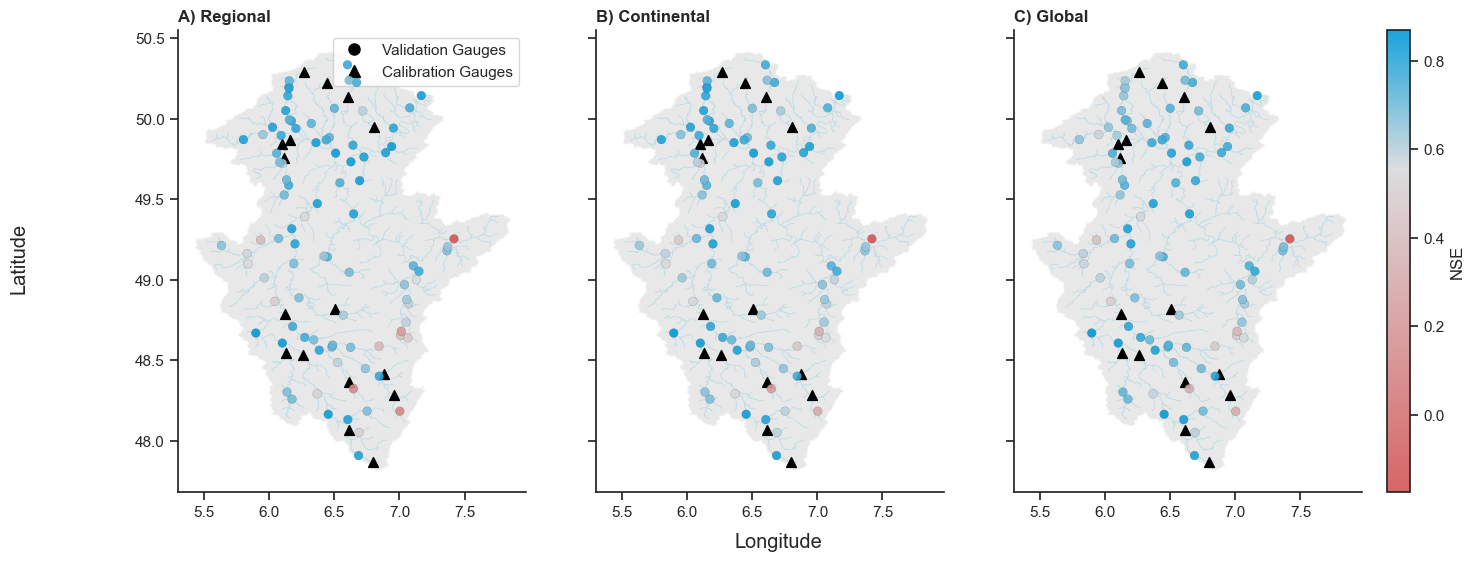

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.lines as mlines

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.7, '#d8dadc'), (1, '#009ad8')]
)

# Create figure with 3 columns
fig, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)

# NSE columns to plot
nse_cols = ['nse_r1', 'nse_c1', 'nse_g1']
titles = ['A) Regional', 'B) Continental', 'C) Global']

for ax, col, title in zip(axes, nse_cols, titles):
    moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
    rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

    # Calibration basins (triangle)
    ax.scatter(
        network_estreams.loc[list_cal, 'lon'],
        network_estreams.loc[list_cal, 'lat'],
        marker='^',
        color='black',
        s=50,
        zorder=3,
        label='Calibrated Basins'
    )

    # NSE scatter
    sc = ax.scatter(
        df['lon'], df['lat'],
        c=df[col],
        cmap=cmap_nse,
        s=40,
        edgecolor='k',
        linewidth=0.1,
        alpha=0.9,
        zorder=10
    )

    ax.set_title(title, loc="left", fontweight="bold")
    ax.set_aspect('auto')
    ax.grid(False)
    sns.despine(ax=ax)

    # Add legend only to the first plot
    if ax == axes[0]:
        validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                          markersize=8, label='Validation Gauges')
        calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                           markersize=8, label='Calibration Gauges')
        ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')

# Shared labels and colorbar
fig.supxlabel("Longitude")
fig.supylabel("Latitude")

# One colorbar for all
#bar = fig.colorbar(sc, ax=axes.ravel().tolist(), label='NSE', shrink=0.8)
# Add a vertical colorbar on the extreme right
cbar = fig.colorbar(
    sc, 
    ax=axes, 
    orientation='vertical', 
    fraction=0.025,  # controls the thickness
    pad=0.02         # controls the distance from the last subplot
)
cbar.set_label('NSE')

#plt.tight_layout()
plt.show()


<Axes: >

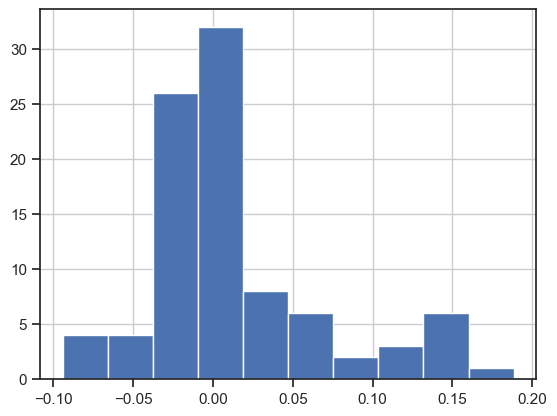

In [164]:
df['nse_rg'].hist()

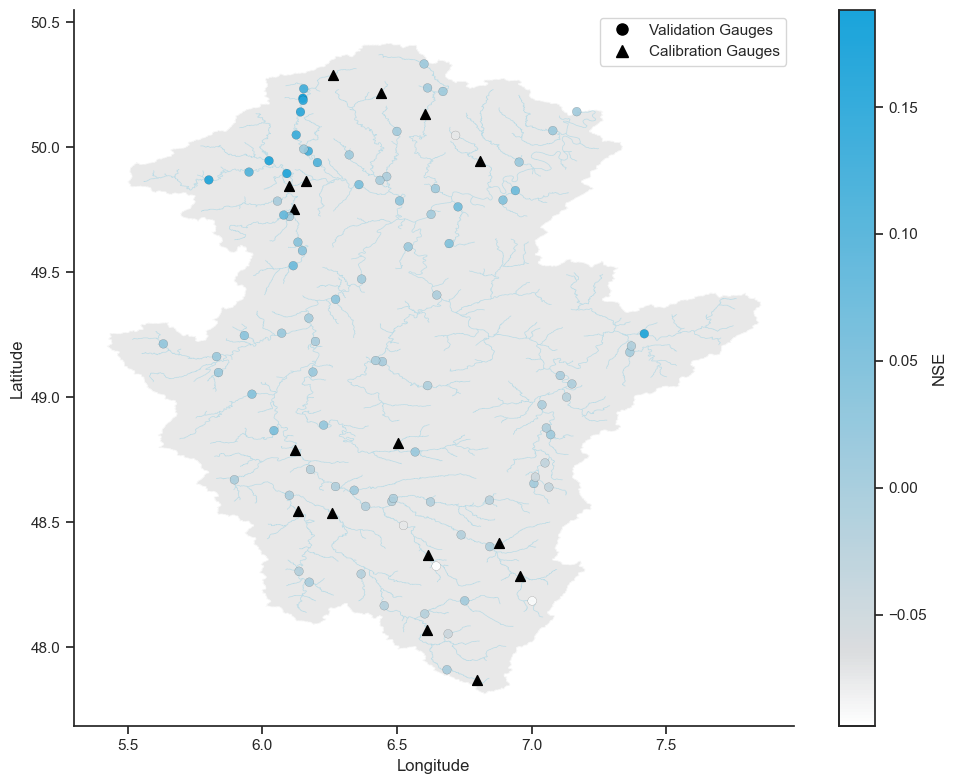

In [168]:
df = data_diff_val_complete.copy()
df[["lon", "lat"]] = estreams_attributes_clipped_filters[["lon", "lat"]]

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, 'white'), (0.1, '#d8dadc'), (1, '#009ad8')]
)


# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

sc = ax.scatter(
    df['lon'], df['lat'],
    c=df['nse_rg'],
    cmap=cmap_nse,
    s=40,
    edgecolor='k',
    linewidth=0.1,
    alpha=0.9,
    zorder=10
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


### Group 2: second half

In [212]:
list_cal = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 #'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [103]:
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_regional2, observations, quality_masks)
nse_results_cal_c_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_continental2, observations, quality_masks)
nse_results_cal_g_2_100 = generate_nse_results(catchments_ids, pd.date_range('2001-10-01', '2015-09-30', freq='D'), output_global2, observations, quality_masks)

path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_88012 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

nse_results_cal_r_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_regional_88012, observations, quality_masks)
nse_results_cal_c_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_continental_88012, observations, quality_masks)
nse_results_cal_g_2_100_8801 = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2001-09-30', freq='D'), output_global_88012, observations, quality_masks)


path_inputs = '../data/models/input/subset_1988_2001'

observations1 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks1 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()

path_inputs = '../data/models/input/subset_2001_2015'

observations2 = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
quality_masks2 = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()


observations_cal = {}

for key in observations1.keys():
    arr1 = np.atleast_1d(observations1[key])
    arr2 = np.atleast_1d(observations2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    observations_cal[key] = np.concatenate([arr1, arr2])

quality_masks_cal = {}

for key in quality_masks1.keys():
    arr1 = np.atleast_1d(quality_masks1[key])
    arr2 = np.atleast_1d(quality_masks2.get(key, np.array([])))

    # Always concatenate arrays, even if they contain NaNs or are empty
    quality_masks_cal[key] = np.concatenate([arr1, arr2])

output_regional_cal2 = {
    key: [np.concatenate([output_regional_88012[key][0], output_regional2[key][0]])]
    for key in output_regional_88012
    if key in output_regional2  # ensures keys match
}

output_continental_cal2 = {
    key: [np.concatenate([output_continental_88012[key][0], output_continental2[key][0]])]
    for key in output_continental_88012
    if key in output_continental2  # ensures keys match
}

output_global_cal2 = {
    key: [np.concatenate([output_global_88012[key][0], output_global2[key][0]])]
    for key in output_global_88012
    if key in output_global2  # ensures keys match
}


nse_results_cal_r_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_cal2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_cal2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_cal = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_cal2, observations_cal, quality_masks_cal)

c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\nascimth\AppData\Local\Temp\ipykernel_18512\1110209421.py:27: RuntimeWarning: invalid value encountered in double_scalars
  metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\hydroanalysis\utils.py:63: UserWarning: Skipped because of no data
  warnings.warn('Skipped because of no data')
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\nascimth\.conda\envs\superf\lib\site-packages\numpy\core\_methods.py:1

In [104]:
data_diff_cal_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_c_2_100_complete_cal.nse)
data_diff_cal_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_cal.nse - nse_results_cal_g_2_100_complete_cal.nse

data_diff_cal_complete2.index = nse_results_cal_c_2_100_complete_cal.basin

data_diff_cal_complete2 = data_diff_cal_complete2.loc[~data_diff_cal_complete2.index.isin(list_cal)]

data_diff_cal_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse
data_diff_cal_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse

data_diff_cal_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi
data_diff_cal_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).nse_value_bfi

data_diff_cal_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_obs
data_diff_cal_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim
data_diff_cal_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).bfi_sim

data_diff_cal_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_obs
data_diff_cal_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim
data_diff_cal_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).qmean_sim

data_diff_cal_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_obs
data_diff_cal_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).slope_sim
data_diff_cal_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).slope_sim

data_diff_cal_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_obs
data_diff_cal_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim
data_diff_cal_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_cal.set_index("basin", inplace = False).hfd_sim


data_diff_cal_complete2 = data_diff_cal_complete2[data_diff_cal_complete2.nse_r1 > -10.0]
data_diff_cal_complete2

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.025793,0.310020,0.829036,0.854830,0.519017,NaN,NaN,NaN,0.515742,0.573456,...,1.307285,1.234615,3.400558,2.743290,3.195068,1.777066,126.294118,137.294118,130.352941,159.352941
BEWA0067,-0.034845,0.234069,0.768075,0.802919,0.534006,NaN,NaN,NaN,0.446878,0.560397,...,1.397150,1.323675,3.527884,2.698627,3.134984,1.860673,123.437500,138.937500,130.562500,154.750000
BEWA0106,-0.029836,0.487017,0.763070,0.792906,0.276053,NaN,NaN,NaN,0.496805,0.572535,...,1.021858,0.983790,4.063631,2.783658,3.291014,1.591152,127.000000,136.521739,133.000000,171.000000
BEWA0107,-0.002470,0.396842,0.759315,0.761785,0.362473,NaN,NaN,NaN,0.565063,0.557326,...,1.429620,1.321399,3.418299,2.795479,3.137608,1.671909,133.588235,141.411765,133.941176,168.588235
BEWA0119,-0.015906,0.310934,0.816860,0.832765,0.505925,NaN,NaN,NaN,0.508101,0.567503,...,1.325504,1.260757,3.336434,2.753243,3.131224,1.822339,123.266667,136.400000,130.600000,157.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.060333,0.383704,0.784399,0.844733,0.400695,NaN,NaN,NaN,0.516853,0.570479,...,1.013724,0.962041,4.331634,2.573227,3.314807,1.744927,121.769231,135.076923,128.000000,164.692308
LU000016,0.113749,0.058466,0.657855,0.544106,0.599389,NaN,NaN,NaN,0.564940,0.555673,...,0.696155,0.690550,2.005883,2.774134,3.753879,3.276128,133.615385,134.384615,130.076923,130.538462
LU000017,-0.018020,0.066757,0.844705,0.862725,0.777947,NaN,NaN,NaN,0.572433,0.606628,...,0.873031,0.845101,2.459555,2.377061,2.690857,1.983503,127.307692,137.769231,133.076923,147.846154


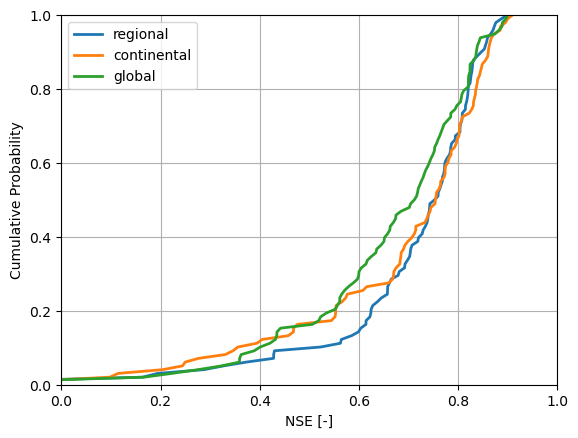

In [105]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

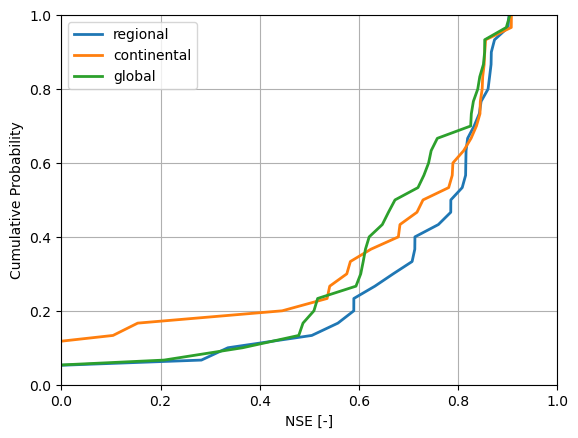

In [106]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_cal_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_cal_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_cal_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


#### Validation

In [108]:
path_inputs = '../data/models/input/subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2, perm_areas_model = perm_areas)
output_continental_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2, perm_areas_model = perm_areascontinental)
output_global_val2 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2, perm_areas_model = perm_areasglobal)

path_inputs = '../data/models/input/subset_2001_2015'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

output_regional_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_r_2_8801, perm_areas_model = perm_areas)
output_continental_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_c_2_8801, perm_areas_model = perm_areascontinental)
output_global_01152 = run_model_superflexpy(catchments_ids = catchments_ids, best_params_dict_model = best_params_dict_model_g_2_8801, perm_areas_model = perm_areasglobal)

In [109]:
output_regional_val_c2 = {
    key: [np.concatenate([output_regional_val2[key][0], output_regional_01152[key][0]])]
    for key in output_regional_01152
    if key in output_regional_val2  # ensures keys match
}

output_continental_val_c2 = {
    key: [np.concatenate([output_continental_val2[key][0], output_continental_01152[key][0]])]
    for key in output_continental_val2
    if key in output_continental_01152  # ensures keys match
}

output_global_val_c2 = {
    key: [np.concatenate([output_global_val2[key][0], output_global_01152[key][0]])]
    for key in output_global_val2
    if key in output_global_01152  # ensures keys match
}

In [110]:
nse_results_cal_r_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_regional_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_c_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_continental_val_c2, observations_cal, quality_masks_cal)
nse_results_cal_g_2_100_complete_val = generate_nse_results(catchments_ids, pd.date_range('1988-10-01', '2015-09-30', freq='D'), output_global_val_c2, observations_cal, quality_masks_cal)

In [134]:
data_diff_val_complete2 = pd.DataFrame(data=nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_c_2_100_complete_val.nse)
data_diff_val_complete2["nse_rg"] = nse_results_cal_r_2_100_complete_val.nse - nse_results_cal_g_2_100_complete_val.nse

data_diff_val_complete2.index = nse_results_cal_c_2_100_complete_val.basin

data_diff_val_complete2 = data_diff_val_complete2.loc[~data_diff_val_complete2.index.isin(list_cal)]

data_diff_val_complete2["nse_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse
data_diff_val_complete2["nse_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse

data_diff_val_complete2["nse_bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi
data_diff_val_complete2["nse_bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).nse_value_bfi

data_diff_val_complete2["bfi_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_obs
data_diff_val_complete2["bfi_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).bfi_sim
data_diff_val_complete2["bfi_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).bfi_sim

data_diff_val_complete2["qmean_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_obs
data_diff_val_complete2["qmean_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).qmean_sim
data_diff_val_complete2["qmean_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).qmean_sim

data_diff_val_complete2["slope_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_obs
data_diff_val_complete2["slope_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).slope_sim
data_diff_val_complete2["slope_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).slope_sim

data_diff_val_complete2["hfd_obs"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_obs
data_diff_val_complete2["hfd_r1"] = nse_results_cal_r_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_c1"] = nse_results_cal_c_2_100_complete_val.set_index("basin", inplace = False).hfd_sim
data_diff_val_complete2["hfd_g1"] = nse_results_cal_g_2_100_complete_val.set_index("basin", inplace = False).hfd_sim


data_diff_val_complete2 = data_diff_val_complete2[data_diff_val_complete2.nse_r1 > -10.0]
data_diff_val_complete2




,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LU000015,-0.008877,0.594414,0.808341,0.817218,0.213927,NaN,NaN,NaN,0.516853,0.571037,...,0.906454,0.889642,4.331634,2.747176,2.931268,1.237538,121.769231,129.923077,129.461538,174.846154
LU000016,0.032608,0.082443,0.612132,0.579524,0.529689,NaN,NaN,NaN,0.564940,0.555008,...,0.638566,0.644934,2.005883,2.862135,3.078900,3.457008,133.615385,130.461538,129.923077,127.000000
LU000017,0.003530,0.087533,0.834798,0.831269,0.747265,NaN,NaN,NaN,0.572433,0.610980,...,0.787699,0.785198,2.459555,2.438855,2.459436,1.693942,127.307692,134.307692,134.538462,147.230769


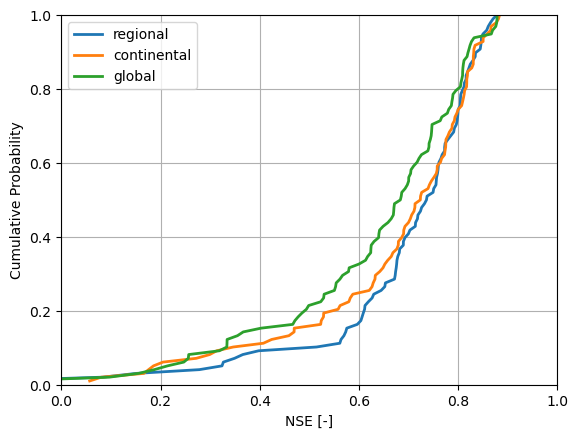

In [135]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

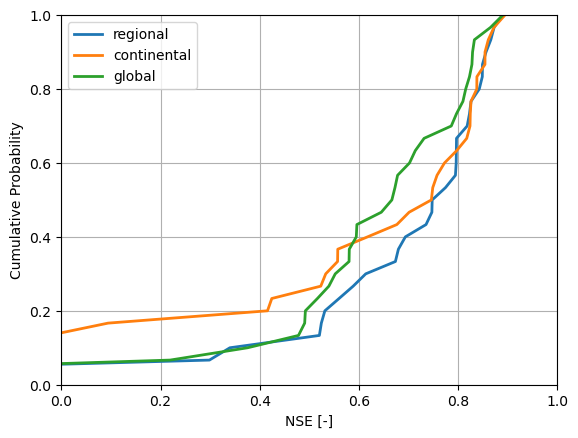

In [115]:
# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_val_complete2["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_val_complete2["nse_bfi_c1"].dropna())
nse_values_3 = np.sort(data_diff_val_complete2["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)
cumulative_3 = np.arange(1, len(nse_values_3) + 1) / len(nse_values_3)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="regional", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="continental", linewidth=2)
plt.plot(nse_values_3, cumulative_3, label="global", linewidth=2)

# Labels and legend
plt.xlabel("NSE [-]")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
#plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

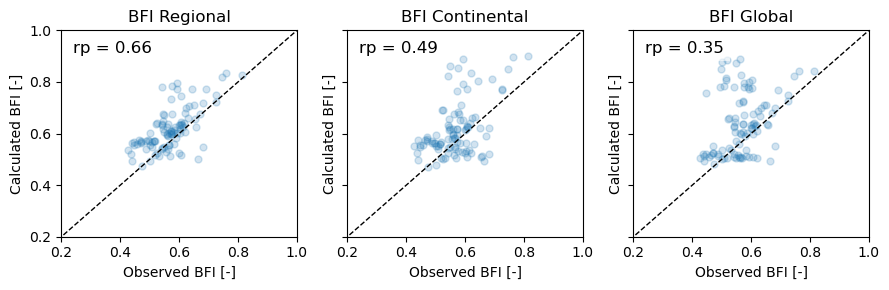

In [117]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['bfi_r1', 'bfi_c1', 'bfi_g1']
titles = ['BFI Regional', 'BFI Continental', 'BFI Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["bfi_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(0.2, 1.0)
    ax.set_ylim(0.2, 1.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

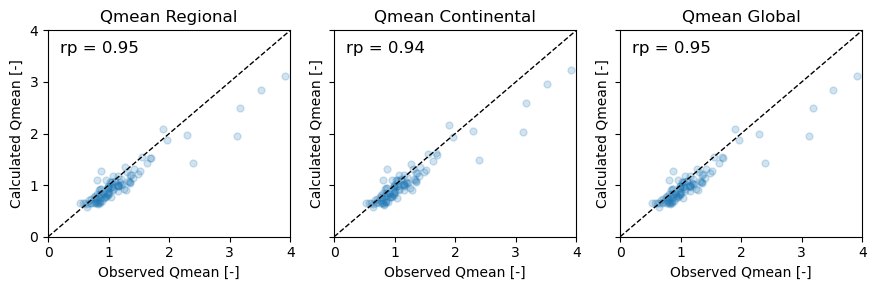

In [119]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['qmean_r1', 'qmean_c1', 'qmean_g1']
titles = ['Qmean Regional', 'Qmean Continental', 'Qmean Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["qmean_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 4], [0, 4], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed Qmean [-]")
    ax.set_ylabel("Calculated Qmean [-]")
    ax.set_title(title)
    ax.set_xlim(0.0, 4.0)
    ax.set_ylim(0.0, 4.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

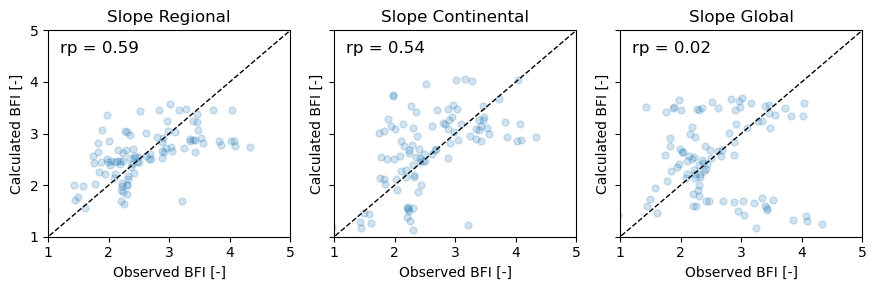

In [121]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['slope_r1', 'slope_c1', 'slope_g1']
titles = ['Slope Regional', 'Slope Continental', 'Slope Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["slope_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([0, 5], [0, 5], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(1, 5.0)
    ax.set_ylim(1, 5.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

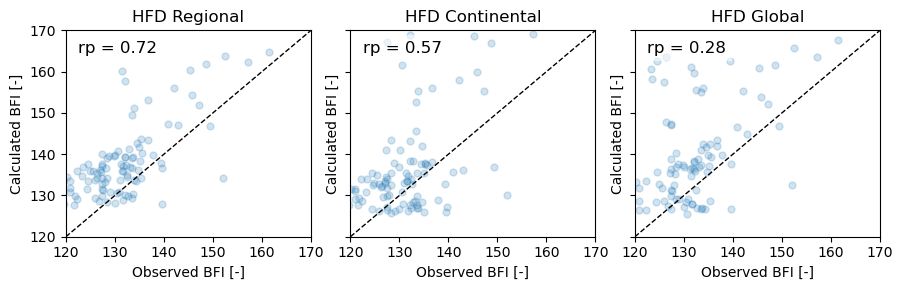

In [122]:
# Set figure and axes
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

# List of variables
variables = ['hfd_r1', 'hfd_c1', 'hfd_g1']
titles = ['HFD Regional', 'HFD Continental', 'HFD Global']

# Loop over each subplot clearly
for ax, var, title in zip(axs, variables, titles):
    
    x = data_diff_val_complete2["hfd_obs"]
    y = data_diff_val_complete2[var]

    ax.scatter(x, y, alpha=0.2, s=25)

    # Plot the 1:1 line
    ax.plot([120, 200], [120, 200], 'k--', linewidth=1)

    # Set labels and title
    ax.set_xlabel("Observed BFI [-]")
    ax.set_ylabel("Calculated BFI [-]")
    ax.set_title(title)
    ax.set_xlim(120, 170.0)
    ax.set_ylim(120, 170.0)

    # Compute Pearson correlation coefficient (R)
    R = np.corrcoef(x, y=data_diff_val_complete2[var])[0, 1]

    # Annotate R clearly on plot (top-left corner)
    ax.text(
        0.05, 0.95, f'rp = {R:.2f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
    )

# Adjust layout
plt.tight_layout()
plt.show()

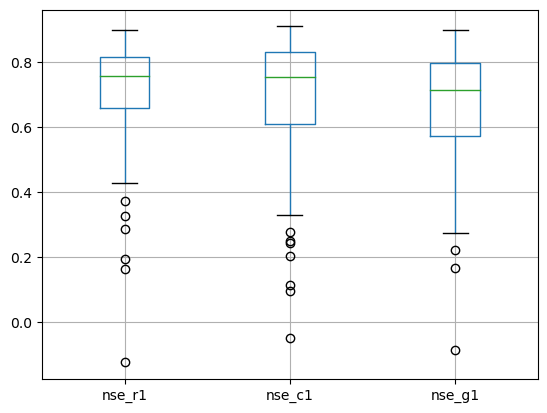

In [124]:


# Plot both columns side by side
data_diff_cal_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



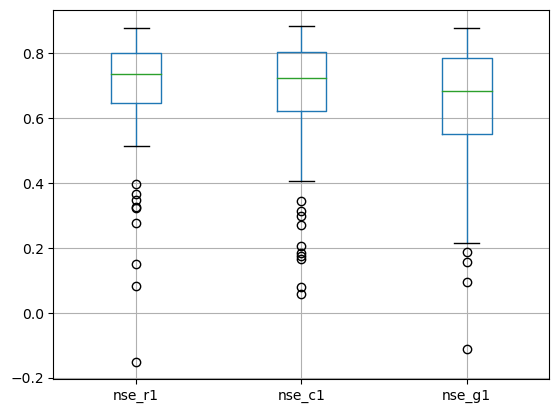

In [125]:


# Plot both columns side by side
data_diff_val_complete2.boxplot(column=["nse_r1","nse_c1", "nse_g1"])

# Show the plot
plt.show()



In [127]:
data_diff_val_complete2[data_diff_val_complete2.nse_r1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333
FR003250,0.070088,-0.005127,0.150458,0.080370,0.155585,NaN,NaN,NaN,0.680834,0.547678,...,1.490959,1.438213,1.818016,2.818138,3.039606,2.907354,152.040000,134.120000,130.080000,132.600000
FR003254,-0.019839,-0.007303,0.326564,0.346403,0.333867,NaN,NaN,NaN,0.723597,0.723494,...,0.901611,0.898634,1.571402,1.975920,1.441068,1.941028,148.625000,161.875000,167.000000,161.500000
FR003259,0.073407,-0.088387,0.278223,0.204816,0.366610,NaN,NaN,NaN,0.570623,0.732099,...,1.305717,1.279329,2.215223,2.042469,1.546628,2.545800,136.647059,153.176471,156.058824,143.411765
FR003280,0.050043,0.015513,0.349008,0.298965,0.333495,NaN,NaN,NaN,0.664153,0.501144,...,0.942279,0.919787,3.012886,3.564313,4.041586,3.689990,139.576923,127.807692,125.884615,126.769231
FR003306,-0.210191,-0.040751,-0.153152,0.057039,-0.112401,NaN,NaN,NaN,0.747143,0.818040,...,0.617547,0.630695,1.611967,1.551600,1.269791,1.468984,157.166667,162.388889,169.222222,163.611111


In [128]:
data_diff_val_complete2[data_diff_val_complete2.nse_g1 < 0.5]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
BEWA0066,-0.005718,0.355179,0.821671,0.827389,0.466492,NaN,NaN,NaN,0.515742,0.571076,...,1.229881,1.190466,3.400558,2.868569,3.061155,1.599769,126.294118,135.352941,132.058824,163.529412
BEWA0067,-0.009087,0.261289,0.755194,0.764281,0.493905,NaN,NaN,NaN,0.446878,0.555953,...,1.289278,1.264698,3.527884,2.914973,3.098414,1.715402,123.437500,136.937500,133.937500,158.187500
BEWA0106,-0.024381,0.494743,0.750625,0.775006,0.255882,NaN,NaN,NaN,0.496805,0.571488,...,1.026590,0.976160,4.063631,2.857153,3.179807,1.408204,127.000000,136.086957,133.043478,173.478261
BEWA0107,0.010143,0.427166,0.761236,0.751093,0.334070,NaN,NaN,NaN,0.565063,0.555682,...,1.408629,1.316139,3.418299,2.874452,3.142920,1.562104,133.588235,139.411765,135.470588,175.529412
BEWA0119,-0.002562,0.319474,0.804388,0.806950,0.484914,NaN,NaN,NaN,0.508101,0.565601,...,1.308257,1.251409,3.336434,2.884838,3.082609,1.748002,123.266667,134.800000,130.933333,160.666667
DERP2013,-0.083075,-0.013097,0.083079,0.166154,0.096176,-0.585098,-0.408345,-0.554157,0.813898,0.827653,...,0.771586,0.778427,0.958560,1.524482,1.192806,1.417545,161.346154,164.807692,179.538462,167.653846
FR000183,-0.009516,-0.004917,0.397711,0.407226,0.402628,NaN,NaN,NaN,0.726346,0.747846,...,1.053525,1.040745,2.204864,1.898045,1.555593,1.833309,147.250000,151.958333,155.250000,152.041667
FR000184,0.180012,0.010754,0.365726,0.185714,0.354972,NaN,NaN,NaN,0.760768,0.832815,...,1.076194,1.069917,1.439657,1.711659,1.161932,1.601227,152.480000,163.760000,179.160000,165.840000
FR000185,0.147979,0.005401,0.323789,0.175810,0.318388,NaN,NaN,NaN,0.541713,0.779659,...,1.106566,1.096805,3.206302,1.692572,1.223568,1.651249,145.277778,160.444444,168.611111,160.833333


In [214]:
data_diff_val_complete2[["lon", "lat"]] = network_estreams[["lon", "lat"]]

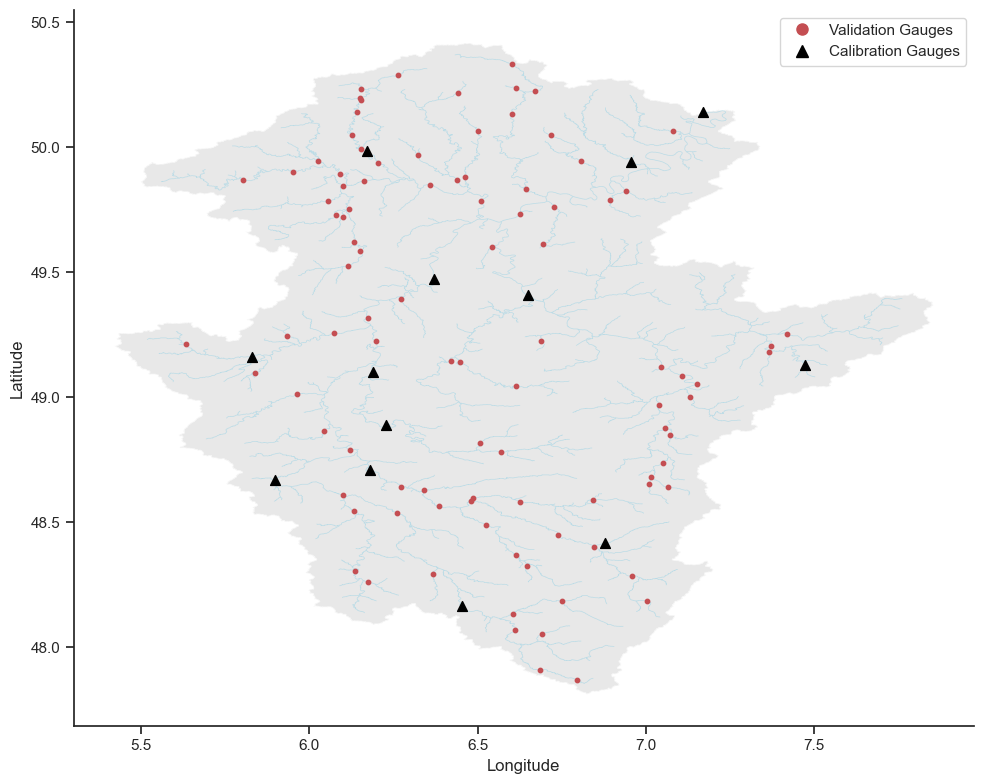

In [252]:
df = data_diff_val_complete2.copy()

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set style
sns.set_theme(style="ticks")

# Custom colormap (red -> gray -> blue)
cmap_nse = LinearSegmentedColormap.from_list(
    'mycmap',
    [(0, '#d35555'), (0.2, '#d8dadc'), (1, '#009ad8')]
)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
moselle.plot(ax=ax, color='lightgray', linewidth=1, alpha=0.5)
rivers_moselle.plot(ax=ax, color='lightblue', linewidth=0.5, alpha=0.75)

ax.scatter(
    network_estreams.loc[list_cal, 'lon'],
    network_estreams.loc[list_cal, 'lat'],
    marker='^',        # triangle
    color='black',     # black
    s=50,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.scatter(
    df.loc[:, 'lon'],
    df.loc[:, 'lat'],
    marker='o',        # triangle
    color='r',     # black
    s=10,              # size of the triangle
    zorder=3,          # on top
    label='Calibrated Basins'
)

ax.set_aspect('auto')  # or 'equal' for 1:1 scale, but you want 'auto' (equal=False)

# Decorations
#plt.colorbar(sc, label="NSE", ax=ax)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
#ax.set_title("NSE Values by Location")
ax.grid(False)
sns.despine()


import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Circle for validation
validation_handle = mlines.Line2D([], [], color='r', marker='o', linestyle='None',
                                  markersize=8, label='Validation Gauges')

# Triangle for calibration
calibration_handle = mlines.Line2D([], [], color='black', marker='^', linestyle='None',
                                   markersize=8, label='Calibration Gauges')

# Add to legend
ax.legend(handles=[validation_handle, calibration_handle], loc='upper right')



plt.tight_layout()
plt.show()


In [ ]:
LU000016

In [251]:
perm_areasglobal

{'BEWA0066': [0.75, 0.25, 0.0],
 'BEWA0067': [0.64, 0.36, 0.0],
 'BEWA0087': [1.0, 0.0, 0.0],
 'BEWA0106': [1.0, 0.0, 0.0],
 'BEWA0107': [1.0, 0.0, 0.0],
 'BEWA0119': [0.75, 0.25, 0.0],
 'DEBU1956': [0.19, 0.73, 0.08],
 'DEBU1957': [0.33, 0.66, 0.01],
 'DEBU1958': [0.28, 0.68, 0.04],
 'DEBU1959': [0.31, 0.65, 0.04],
 'DERP2003': [0.5, 0.5, 0.0],
 'DERP2004': [0.59, 0.41, 0.0],
 'DERP2005': [0.0, 1.0, 0.0],
 'DERP2006': [0.0, 1.0, 0.0],
 'DERP2007': [0.07, 0.93, 0.0],
 'DERP2008': [0.01, 0.99, 0.0],
 'DERP2010': [0.23, 0.77, 0.0],
 'DERP2011': [0.23, 0.77, 0.0],
 'DERP2013': [0.92, 0.08, 0.0],
 'DERP2014': [0.67, 0.33, 0.0],
 'DERP2015': [0.49, 0.51, 0.0],
 'DERP2016': [0.32, 0.68, 0.0],
 'DERP2017': [0.74, 0.26, 0.0],
 'DERP2018': [0.75, 0.25, 0.0],
 'DERP2021': [0.02, 0.98, 0.0],
 'DERP2022': [0.14, 0.76, 0.1],
 'DERP2023': [0.14, 0.77, 0.09],
 'DERP2024': [0.3, 0.65, 0.05],
 'DERP2027': [0.18, 0.78, 0.04],
 'DERP2028': [0.79, 0.2, 0.01],
 'DERP2029': [0.75, 0.25, 0.0],
 'DERP2030': [

In [248]:
data_diff_val_complete.iloc[50:]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1,lon,lat
basin,,,,,,,,,,,,,,,,,,,,,
FR003237,-0.010695,-0.025205,0.830886,0.841580,0.856091,0.845793,0.810661,0.859823,0.582925,0.573563,...,2.455219,2.656551,2.647317,2.619848,132.269231,129.038462,129.884615,131.346154,6.452981,48.165666
FR003239,0.009453,-0.003134,0.588980,0.579528,0.592114,NaN,NaN,NaN,0.541757,0.624275,...,1.733716,2.572342,2.804096,2.512157,127.391304,133.130435,129.086957,133.521739,6.367100,48.292520
FR003241,-0.007894,-0.027964,0.837770,0.845664,0.865734,NaN,NaN,NaN,0.572007,0.591357,...,2.665677,2.601466,2.564830,2.552515,127.500000,127.045455,127.954545,129.000000,6.260215,48.536107
FR003246,0.015625,0.018337,0.752508,0.736883,0.734171,NaN,NaN,NaN,0.470773,0.550802,...,2.979324,3.181073,2.780996,3.241284,120.840000,127.440000,130.720000,127.040000,6.131546,48.545356
FR003249,-0.000189,-0.011399,0.865700,0.865889,0.877099,NaN,NaN,NaN,0.579674,0.597453,...,2.729270,2.721966,2.555754,2.670418,128.307692,129.653846,131.000000,130.884615,5.896402,48.669764
FR003250,-0.084235,-0.155093,0.094741,0.178975,0.249834,NaN,NaN,NaN,0.680834,0.526290,...,1.818016,2.954627,2.715800,2.650297,152.040000,128.280000,131.240000,131.800000,7.002529,48.184730
FR003251,0.067694,-0.014822,0.783474,0.715780,0.798296,NaN,NaN,NaN,0.628729,0.654936,...,2.109643,2.213135,2.603438,2.187480,137.863636,135.636364,129.590909,137.136364,6.845062,48.402032
FR003252,0.055869,-0.021724,0.675042,0.619172,0.696766,NaN,NaN,NaN,0.669344,0.675448,...,2.087440,2.098826,2.495875,2.182795,149.333333,143.333333,137.416667,143.583333,6.738613,48.449237
FR003254,-0.071523,-0.024247,0.395169,0.466692,0.419416,NaN,NaN,NaN,0.723597,0.725719,...,1.571402,1.875206,1.556467,1.926381,148.625000,158.500000,160.625000,157.375000,6.843861,48.588049


# Further analysis

In [305]:
estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.q_runoff_ratio<0.3]

,gauge_id,gauge_name,gauge_country,gauge_provider,river,lon_snap,lat_snap,lon,lat,elevation,...,sno_cov_mean,irri_1990,irri_2005,stations_num_p_mean,perm_high_regi,perm_medium_regi,perm_low_regi,perm_high_glob2,perm_medium_glob2,perm_low_glob2
basin_id,,,,,,,,,,,,,,,,,,,,,
BEWA0087,56100000,Martelange,BE,BE_SPW,Sure,5.739269,49.833704,5.739269,49.833704,NaN,...,6.106,0.000,0.000,6.0,0.0,0.0,100.0,100.0,0.0,0.0
FR000174,A812200001,A8122000,FR,FR_EAUFRANCE,L'Yron à Hannonville-Suzémont,5.837081,49.098776,5.837081,49.098776,197,...,2.131,0.070,0.040,2.0,0.0,100.0,0.0,1.0,99.0,0.0
FR003259,A664031002,L'ArentÃƒÂ¨le ÃƒÂ Saint-Gorgon et ÃƒÂ Sainte...,FR,FR_EAUFRANCE,L'Arentèle à Saint-Gorgon et à Sainte-Hélène,6.645964,48.324169,6.645964,48.324169,295,...,3.622,0.011,0.009,2.0,66.0,34.0,0.0,35.0,65.0,0.0
FR003266,A712201001,L'Esch Ã Jezainville,FR,FR_EAUFRANCE,L'Esch à Jezainville,6.043284,48.866376,6.043284,48.866376,182,...,2.120,0.025,0.057,2.0,0.0,100.0,0.0,0.0,100.0,0.0


In [308]:
data_diff_cal_complete.loc[["FR000174", "FR003259", "FR003266"]]

,nse,nse_rg,nse_r1,nse_c1,nse_g1,nse_bfi_r1,nse_bfi_c1,nse_bfi_g1,bfi_obs,bfi_r1,...,qmean_c1,qmean_g1,slope_obs,slope_r1,slope_c1,slope_g1,hfd_obs,hfd_r1,hfd_c1,hfd_g1
basin,,,,,,,,,,,,,,,,,,,,,
FR000174,0.030850,-0.000239,0.591608,0.560758,0.591847,NaN,NaN,NaN,0.437861,0.507505,...,0.720963,0.730438,3.730071,3.480109,4.070957,3.285338,117.923077,129.769231,130.000000,131.000000
FR003259,-0.032133,-0.111755,0.256759,0.288892,0.368514,NaN,NaN,NaN,0.570623,0.748932,...,1.313141,1.307574,2.215223,1.854404,1.809174,2.474283,136.647059,152.117647,151.764706,141.411765
FR003266,-0.010001,0.047898,0.542852,0.552853,0.494954,NaN,NaN,NaN,0.567523,0.488606,...,0.690247,0.696934,4.039029,3.712760,3.667047,3.430468,130.000000,124.363636,126.681818,126.681818


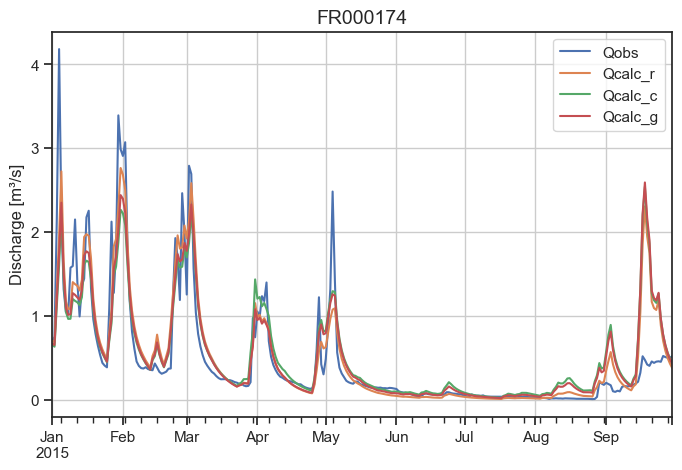

In [312]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000174"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2015"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

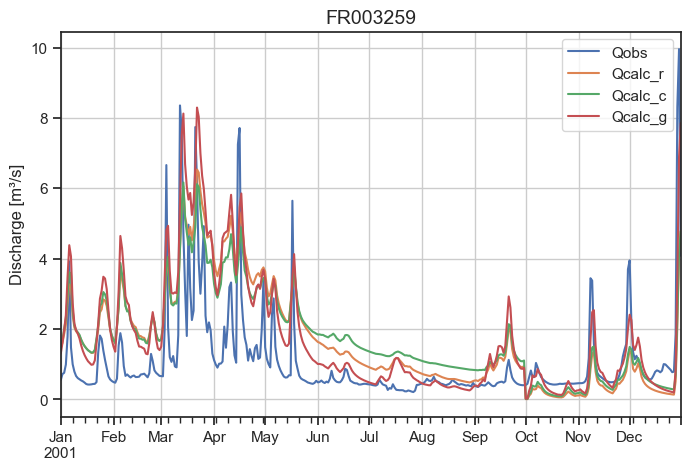

In [317]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003259"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2001"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

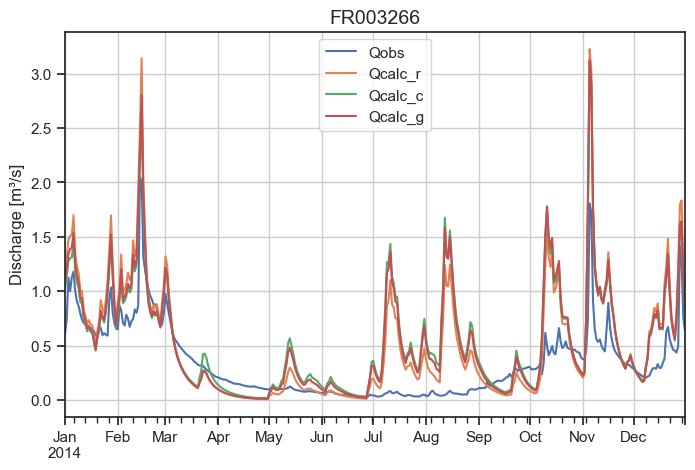

In [319]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR003266"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["2014"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

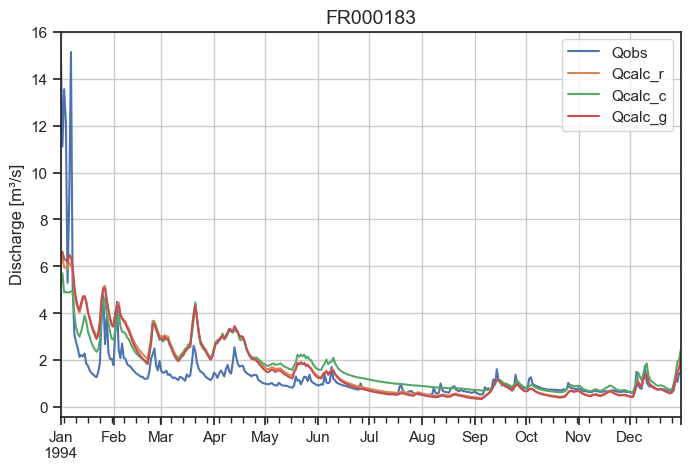

In [334]:
Qtimeseries = pd.DataFrame(index = pd.date_range('10-01-1988','09-30-2015', freq='D'))

gauge_id="FR000183"

Qtimeseries["Qobs"] = observations_cal[gauge_id]
Qtimeseries["Qcalc_r"] = output_regional_val_c[gauge_id][0]
Qtimeseries["Qcalc_c"] = output_continental_val_c[gauge_id][0]
Qtimeseries["Qcalc_g"] = output_global_val_c[gauge_id][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

fig, ax = plt.subplots(figsize=(8, 5))

Qtimeseries.loc["1994"].plot(ax=ax)

# Add title with gauge ID
ax.set_title(f"{gauge_id}", fontsize=14)

# Add labels if you want
ax.set_ylabel("Discharge [m³/s]")
#ax.set_xlabel("Date")
ax.grid(True)

In [335]:
list_cal

['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']

In [336]:
nse_results_cal_r_1_100[nse_results_cal_r_1_100.basin == gauge_id]

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
51,A9001050,FR000183,0.813653,0.701242,0.744249,NaN,1.099647,1.045212,1.964987,1.973349,146.272727,149.363636


In [337]:
nse_results_cal_r_1_100

,gauge_name,basin,nse,bfi_obs,bfi_sim,nse_value_bfi,qmean_obs,qmean_sim,slope_obs,slope_sim,hfd_obs,hfd_sim
0,Reuland,BEWA0066,0.848794,0.514795,0.548222,0.864637,1.238351,1.163753,3.347668,2.688420,125.769231,131.846154
1,Schoenberg,BEWA0067,0.802846,0.448057,0.530274,0.815041,1.412586,1.264227,3.448610,2.755547,122.307692,131.846154
2,Martelange,BEWA0087,-19.559708,0.715474,0.514520,NaN,0.196649,1.218498,1.740044,2.755850,149.666667,125.416667
3,Reuland,BEWA0106,0.771835,0.481832,0.549566,NaN,1.011804,0.901341,4.246454,2.674293,126.153846,132.769231
4,Lommersweiler,BEWA0107,0.733169,0.569622,0.545603,NaN,1.142034,1.248445,3.281075,2.697986,131.250000,134.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
107,Michelau,LU000015,0.780712,0.524064,0.544619,0.828639,1.040332,1.017226,4.286267,2.764151,121.769231,128.615385
108,Pfaffenthal,LU000016,0.672278,0.567054,0.549926,0.446167,0.801764,0.740183,2.023796,2.837984,133.615385,130.846154
109,Rosport,LU000017,0.865073,0.577206,0.593668,0.885683,0.935842,0.893069,2.468492,2.448700,127.307692,133.000000
110,Schoenfels,LU000018,0.630301,0.549042,0.658087,0.512632,0.876011,0.789524,2.255653,2.105457,127.384615,139.461538
